<p style="font-size:36px;text-align:center"> <b>Cancer diagnosis</b> </p>

<h1>Business Problem </h1>

<p>Classification of Cancer Classes based upon the Gene, Var, Text</p>
<p> Data Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/ </p>
<p> Data: Memorial Sloan Kettering Cancer Center (MSKCC)</p>
<p> Download training_variants.zip and training_text.zip from Kaggle.</p> 

<h3> Problem statement : </h3>
<p> Classify the given genetic variations/mutations based on evidence from text-based clinical literature. </p>

<h2>Business Constraints</h2>

* No low-latency requirement.
* Interpretability is important.
* Errors can be very costly.
* Probability of a data-point belonging to each class is needed(Very Important).

<h1>Machine Learning Problem Formulation</h1>

<h3>Data</h3>

- Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/data
- We have two data files: one conatins the information about the genetic mutations and the other contains the clinical evidence (text) that  human experts/pathologists use to classify the genetic mutations. 
- Both these data files are have a common column called ID
- <p> 
    Data file's information:
    <ul> 
        <li>
        training_variants (ID , Gene, Variations, Class)
        </li>
        <li>
        training_text (ID, Text)
        </li>
    </ul>
</p>

<h3>Performance Metric</h3>

- MultiClass Log-Loss
- Confusion Matrix
- Precision
- Recall

<h3>Visualizations of metrics</h3>

- Heat Map
- bar charts

# Exploratory Data Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
import seaborn as sns
import math
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score,log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

E:\anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Reading Data

### Reading Gene and Variation Data

In [2]:
data = pd.read_csv('training_variants')
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)
data.head()

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


ID    Gene             Variation  Class
0   0  FAM58A  Truncating Mutations      1
1   1     CBL                 W802*      2
2   2     CBL                 Q249E      2
3   3     CBL                 N454D      3
4   4     CBL                 L399V      4

<p>
    training/training_variants is a comma separated file containing the description of the genetic mutations used for training. <br>
    Fields are 
    <ul>
        <li><b>ID : </b>the id of the row used to link the mutation to the clinical evidence</li>
        <li><b>Gene : </b>the gene where this genetic mutation is located </li>
        <li><b>Variation : </b>the aminoacid change for this mutations </li>
        <li><b>Class :</b> 1-9 the class this genetic mutation has been classified on</li>
    </ul>

### Reading Text Data

In [3]:
text = pd.read_csv('training_text',sep="\|\|",engine='python',names=['ID','Text'],skiprows=1)
print('No. of Data Points : ',text.shape[0])
print('No. of Features : ',text.shape[1])
text.head()

No. of Data Points :  3321
No. of Features :  2


ID                                               Text
0   0  Cyclin-dependent kinases (CDKs) regulate a var...
1   1   Abstract Background  Non-small cell lung canc...
2   2   Abstract Background  Non-small cell lung canc...
3   3  Recent evidence has demonstrated that acquired...
4   4  Oncogenic mutations in the monomeric Casitas B...

### Preprocessing of text


- Replacing every special character with space
- Replacing multiple spaces with single
- Converting all letters to lower case
- Eliminating stop words

In [4]:
stop_words = set(stopwords.words('english'))
def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        ### Replace every special character with space
        total_text = re.sub('[^a-zA-Z0-9\n]',' ',total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        text[column][index] = string

In [5]:
#text processing stage.
start_time = time.clock()
for index, row in text.iterrows():
    nlp_preprocessing(row['Text'], index, 'Text')
print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")

Time took for preprocessing the text : 263.87423016758964 seconds


The two dataset must be merged inorder to perform further computation.The following merge operation is similar to join operation in sql

In [6]:
#merging both gene_variations and text data based on ID
result = pd.merge(data, text,on='ID', how='left')
result.head()

ID    Gene             Variation  Class  \
0   0  FAM58A  Truncating Mutations      1   
1   1     CBL                 W802*      2   
2   2     CBL                 Q249E      2   
3   3     CBL                 N454D      3   
4   4     CBL                 L399V      4   

                                                Text  
0  cyclin dependent kinases cdks regulate variety...  
1  abstract background non small cell lung cancer...  
2  abstract background non small cell lung cancer...  
3  recent evidence demonstrated acquired uniparen...  
4  oncogenic mutations monomeric casitas b lineag...

### Test, Train and Cross Validation Split

In [7]:
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

We have done random spliting in order to preserve class ratios

In [8]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


#### Distribution of output labels in all three datasets 

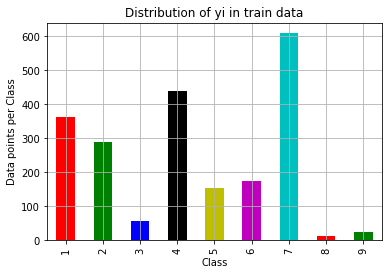

Number of data points in class 7 : 609 ( 28.672 %)
Number of data points in class 4 : 439 ( 20.669 %)
Number of data points in class 1 : 363 ( 17.09 %)
Number of data points in class 2 : 289 ( 13.606 %)
Number of data points in class 6 : 176 ( 8.286 %)
Number of data points in class 5 : 155 ( 7.298 %)
Number of data points in class 3 : 57 ( 2.684 %)
Number of data points in class 9 : 24 ( 1.13 %)
Number of data points in class 8 : 12 ( 0.565 %)
--------------------------------------------------------------------------------


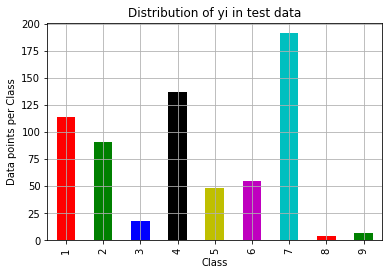

Number of data points in class 7 : 191 ( 28.722 %)
Number of data points in class 4 : 137 ( 20.602 %)
Number of data points in class 1 : 114 ( 17.143 %)
Number of data points in class 2 : 91 ( 13.684 %)
Number of data points in class 6 : 55 ( 8.271 %)
Number of data points in class 5 : 48 ( 7.218 %)
Number of data points in class 3 : 18 ( 2.707 %)
Number of data points in class 9 : 7 ( 1.053 %)
Number of data points in class 8 : 4 ( 0.602 %)
--------------------------------------------------------------------------------


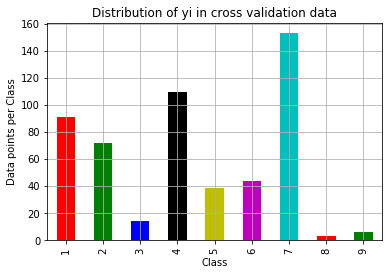

Number of data points in class 7 : 153 ( 28.759 %)
Number of data points in class 4 : 110 ( 20.677 %)
Number of data points in class 1 : 91 ( 17.105 %)
Number of data points in class 2 : 72 ( 13.534 %)
Number of data points in class 6 : 44 ( 8.271 %)
Number of data points in class 5 : 39 ( 7.331 %)
Number of data points in class 3 : 14 ( 2.632 %)
Number of data points in class 9 : 6 ( 1.128 %)
Number of data points in class 8 : 3 ( 0.564 %)


In [9]:
# it returns a dict, keys as class labels and values as the number of data points in that class
train_class_distribution = train_df['Class'].value_counts().sortlevel()
test_class_distribution = test_df['Class'].value_counts().sortlevel()
cv_class_distribution = cv_df['Class'].value_counts().sortlevel()

my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar', color=my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%)')

    
print('-'*80)
my_colors = 'rgbkymc'
test_class_distribution.plot(kind='bar', color=my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), '%)')

print('-'*80)
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar', color=my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), '%)')


To check how our model is performing atleast better than random model we have to first design a random model as log-loss ranges from 0 to inf 

## Predicting using a random model

### Plotting heatmap of the confusion_matrix and precision and recall

In [8]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix C", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

Log loss on Cross Validation Data using Random Model 2.4086394103488757
Log loss on Test Data using Random Model 2.487305699122977
-------------------- Confusion matrix C --------------------


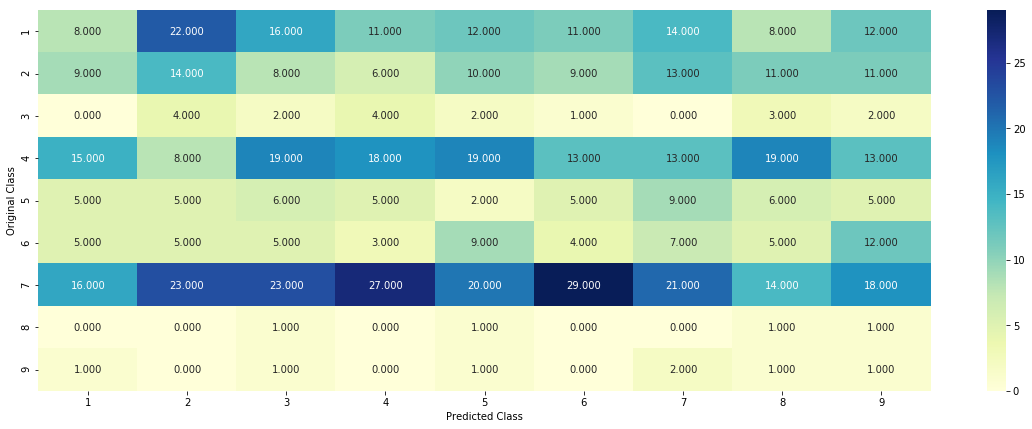

-------------------- Precision matrix (Columm Sum=1) --------------------


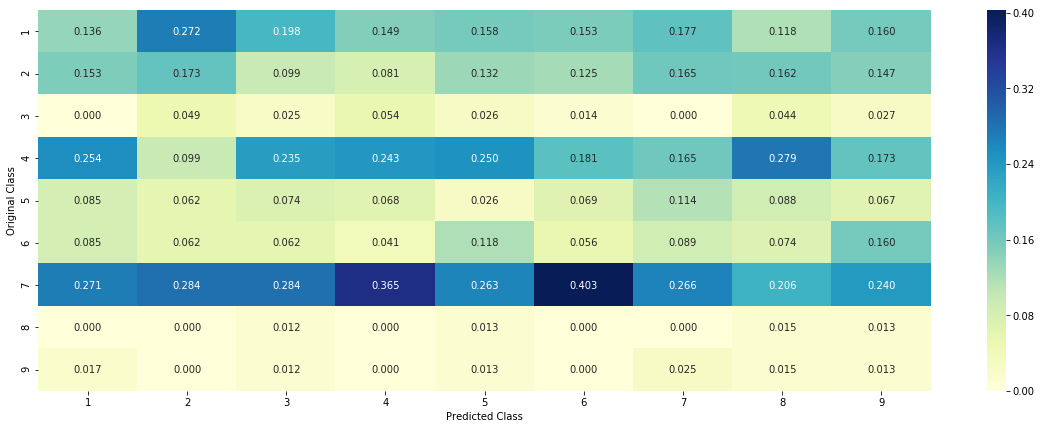

-------------------- Recall matrix (Row sum=1) --------------------


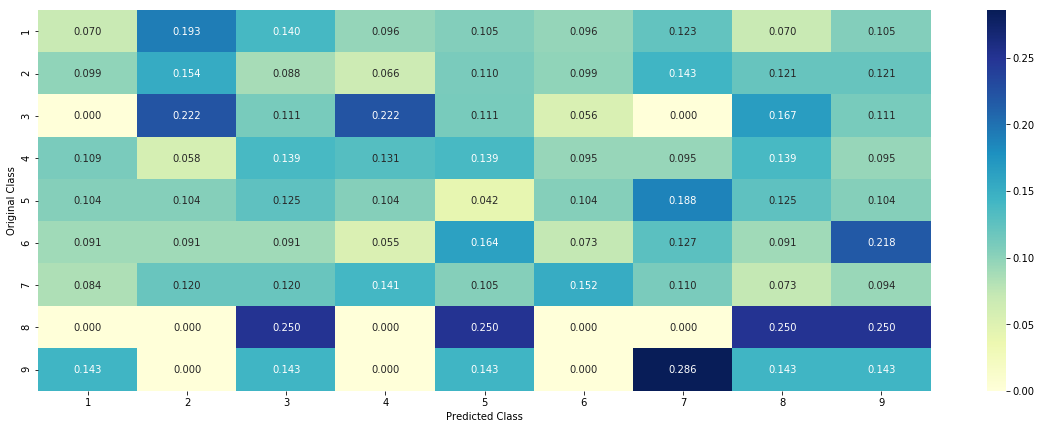

In [12]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = list(np.random.rand(1,9))
    #print(rand_probs,"sum",sum(rand_probs),"sum of sum",sum(sum(rand_probs)))
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs))))
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))


# Test-Set error.
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs))))
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))
#print("Accuracy Score on test data ",accuracy_score(y_test,test_predicted_y))
predicted_y =np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test,predicted_y+1)

## Univariate Analysis

This must be done in order to find how much each feature contributes to classify between different classes. Univariate analysis also provides a sense of feature importance

In [9]:
def get_gv_fea_dict(alpha, feature, df):
    
    value_count = train_df[feature].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 9 diamensional vector
        vec = []
        for k in range(1,10):
            # print(train_df.loc[(train_df['Class']==1) & (train_df['Gene']=='BRCA1')])
            #         ID   Gene             Variation  Class  
            # 2470  2470  BRCA1                S1715C      1   
            # 2486  2486  BRCA1                S1841R      1   
            # 2614  2614  BRCA1                   M1R      1   
            # 2432  2432  BRCA1                L1657P      1   
            # 2567  2567  BRCA1                T1685A      1   
            # 2583  2583  BRCA1                E1660G      1   
            # 2634  2634  BRCA1                W1718L      1   
            # cls_cnt.shape[0] will return the number of rows

            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
        #print(gv_dict)
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = train_df[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea

for the genes which are not present in training data but are present in cross-validation or test data we have to assign same response probability for this we will use laplace smoothing. 

## Univariate analysis on gene

<p style="font-size:18px;"> <b>Q1.</b> Gene, What type of feature it is ?</p>
<p style="font-size:16px;"><b>Ans.</b> Gene is a categorical variable </p>
<p style="font-size:18px;"> <b>Q2.</b> How many categories are there and How they are distributed?</p>

In [14]:
unique_genes = train_df['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
# the top 10 genes that occured most
print(unique_genes.head(10))

Number of Unique Genes : 241
BRCA1     172
TP53      106
EGFR       92
PTEN       80
BRCA2      72
KIT        64
BRAF       58
ERBB2      54
ALK        41
PDGFRA     37
Name: Gene, dtype: int64


In [15]:
print("Ans: There are", unique_genes.shape[0] ,"different categories of genes in the train data, and they are distibuted as follows",)

Ans: There are 241 different categories of genes in the train data, and they are distibuted as follows


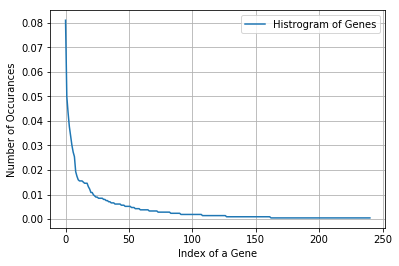

In [16]:
s = sum(unique_genes.values);
h = unique_genes.values/s;
plt.plot(h, label="Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()


The distribution of gene is skewed, as a result Id has same gene

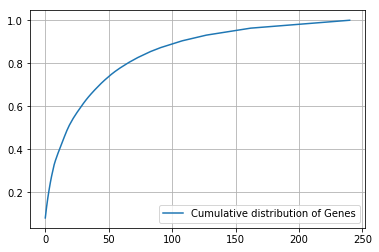

In [17]:
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

Due to the fact gene is a categorical variable we have to encode the variable either by using:
- One hot Encoding
- Response coding
    

## Gene Encoding

In [10]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

# bigrams.
gene_vectorizer_bigram = CountVectorizer(ngram_range=(1,2))
train_gene_feature_bigram = gene_vectorizer_bigram.fit_transform(train_df['Gene'])
test_gene_feature_bigram = gene_vectorizer_bigram.transform(test_df['Gene'])
cv_gene_feature_bigram = gene_vectorizer_bigram.transform(cv_df['Gene'])


#  Tf-idf encoding  
tfidf_vect = TfidfVectorizer(ngram_range=(1,2))
train_gene_tfidf = tfidf_vect.fit_transform(train_df['Gene'])
test_gene_tfidf = tfidf_vect.transform(test_df['Gene'])
cv_gene_tfidf = tfidf_vect.transform(cv_df['Gene'])

In [19]:
print("train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature:", train_gene_feature_responseCoding.shape)

train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature: (2124, 9)


In [174]:
print("train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature:", train_gene_tfidf.shape)

train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature: (2124, 240)


In [175]:
print("train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature:", train_gene_feature_bigram.shape)

train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature: (2124, 240)


In [22]:
print("train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature:", train_gene_feature_onehotCoding.shape)

train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature: (2124, 240)


One simple benifit of using response encoding over one hot encoding is that the dimension of data can some times becomes very large using one-hot encoding

<p style="font-size:18px;"> <b>Q4.</b> How good is this gene feature  in predicting y_i?</p>

There are many ways to estimate how good a feature is, in predicting y_i. One of the good methods is to build a proper ML model using just this feature. In this case, we will build a logistic regression model using only Gene feature (one hot encoded) to predict y_i.

For values of alpha =  1e-05 The log loss is: 1.3320928986450098
For values of alpha =  0.0001 The log loss is: 1.1450658955521649
For values of alpha =  0.001 The log loss is: 1.1811915252427332
For values of alpha =  0.01 The log loss is: 1.3196362485292938
For values of alpha =  0.1 The log loss is: 1.439631551187482
For values of alpha =  1 The log loss is: 1.4784291132028193


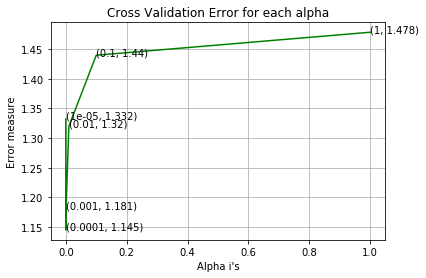

For values of best alpha =  0.0001 The train log loss is: 1.0480516304701641
For values of best alpha =  0.0001 The cross validation log loss is: 1.1450658955521649
For values of best alpha =  0.0001 The test log loss is: 1.2405516871530804


In [50]:
############ Using one hot encoding #############

alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of alpha =  1e-05 The log loss is: 1.3320928986450098
For values of alpha =  0.0001 The log loss is: 1.1450658955521649
For values of alpha =  0.001 The log loss is: 1.1811915252427332
For values of alpha =  0.01 The log loss is: 1.3196362485292938
For values of alpha =  0.1 The log loss is: 1.439631551187482
For values of alpha =  1 The log loss is: 1.4784291132028193


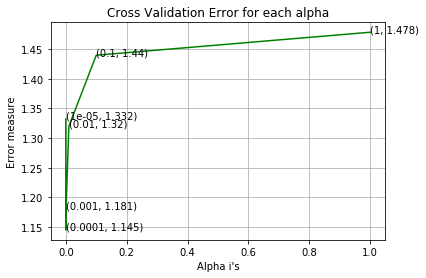

For values of best alpha =  0.0001 The train log loss is: 1.0480516304701641
For values of best alpha =  0.0001 The cross validation log loss is: 1.1450658955521649
For values of best alpha =  0.0001 The test log loss is: 1.2405516871530804


In [176]:
############ Using unigrams #############

alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_bigram, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_bigram, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_bigram)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_bigram, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_bigram)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_bigram)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_bigram)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of alpha =  1e-05 The log loss is: 1.3320928986450098
For values of alpha =  0.0001 The log loss is: 1.1450658955521649
For values of alpha =  0.001 The log loss is: 1.1811915252427332
For values of alpha =  0.01 The log loss is: 1.3196362485292938
For values of alpha =  0.1 The log loss is: 1.439631551187482
For values of alpha =  1 The log loss is: 1.4784291132028193


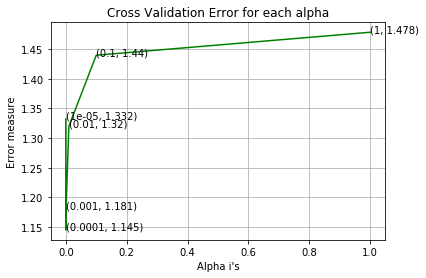

For values of best alpha =  0.0001 The train log loss is: 1.0480516304701641
For values of best alpha =  0.0001 The cross validation log loss is: 1.1450658955521649
For values of best alpha =  0.0001 The test log loss is: 1.2405516871530804


In [52]:
############ Using tfidf vector #############

alpha_tfidf = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.


cv_log_error_array_tfidf=[]
for i in alpha_tfidf:
    clf_tfidf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf_tfidf.fit(train_gene_tfidf, y_train)
    sig_clf_tfidf = CalibratedClassifierCV(clf_tfidf, method="sigmoid")
    sig_clf_tfidf.fit(train_gene_tfidf, y_train)
    predict_y_tfidf = sig_clf_tfidf.predict_proba(cv_gene_tfidf)
    cv_log_error_array_tfidf.append(log_loss(y_cv, predict_y_tfidf, labels=clf_tfidf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y_tfidf, labels=clf_tfidf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array_tfidf,c='g')
for i, txt in enumerate(np.round(cv_log_error_array_tfidf,3)):
    ax.annotate((alpha_tfidf[i],np.round(txt,3)), (alpha_tfidf[i],cv_log_error_array_tfidf[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array_tfidf)
clf_tfidf = SGDClassifier(alpha=alpha_tfidf[best_alpha], penalty='l2', loss='log', random_state=42)
clf_tfidf.fit(train_gene_tfidf, y_train)
sig_clf_tfidf = CalibratedClassifierCV(clf_tfidf, method="sigmoid")
sig_clf_tfidf.fit(train_gene_tfidf, y_train)

predict_y = sig_clf_tfidf.predict_proba(train_gene_tfidf)
print('For values of best alpha = ', alpha_tfidf[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf_tfidf.predict_proba(cv_gene_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf_tfidf.predict_proba(test_gene_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of alpha =  1e-05 The log loss is: 1.2363920817491443
For values of alpha =  0.0001 The log loss is: 1.2391579386760245
For values of alpha =  0.001 The log loss is: 1.3009025687051523
For values of alpha =  0.01 The log loss is: 1.3363878935169329
For values of alpha =  0.1 The log loss is: 1.3425104787403546
For values of alpha =  1 The log loss is: 1.3521302660873822


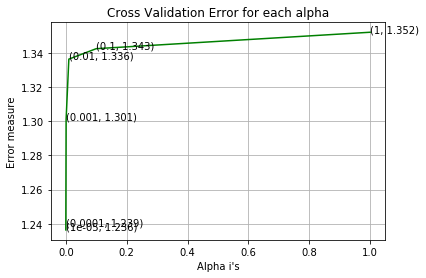

For values of best alpha =  1e-05 The train log loss is: 1.202049939116666
For values of best alpha =  1e-05 The cross validation log loss is: 1.2363920817491443
For values of best alpha =  1e-05 The test log loss is: 1.3478362174007639


In [48]:
############ Using Response encoding #############

alpha_response = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.

cv_log_error_array_response=[]
for i in alpha_response:
    clf_response = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf_response.fit(train_gene_feature_responseCoding, y_train)
    sig_clf_response = CalibratedClassifierCV(clf_response, method="sigmoid")
    sig_clf_response.fit(train_gene_feature_responseCoding, y_train)
    predict_y_response = sig_clf_response.predict_proba(cv_gene_feature_responseCoding)
    cv_log_error_array_response.append(log_loss(y_cv, predict_y_response, labels=clf_response.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y_response, labels=clf_response.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha_response, cv_log_error_array_response,c='g')
for i, txt in enumerate(np.round(cv_log_error_array_response,3)):
    ax.annotate((alpha_response[i],np.round(txt,3)), (alpha_response[i],cv_log_error_array_response[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array_response)
clf_response = SGDClassifier(alpha=alpha_response[best_alpha], penalty='l2', loss='log', random_state=42)
clf_response.fit(train_gene_feature_responseCoding, y_train)
sig_clf_response = CalibratedClassifierCV(clf_response, method="sigmoid")
sig_clf_response.fit(train_gene_feature_responseCoding ,y_train)
,
predict_y = sig_clf_response.predict_proba(train_gene_feature_responseCoding)
print('For values of best alpha = ', alpha_response[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf_response.predict_proba(cv_gene_feature_responseCoding)
print('For values of best alpha = ', alpha_response[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf_response.predict_proba(test_gene_feature_responseCoding)
print('For values of best alpha = ', alpha_response[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


<p style="font-size:18px;"> <b>Q5.</b> Is the Gene feature stable across all the data sets (Test, Train, Cross validation)?</p>
<p style="font-size:16px;"> <b>Ans.</b> Yes, it is. Otherwise, the CV and Test errors would be significantly more than train error. </p>

In [76]:
print("Q6. How many data points in Test and CV datasets are covered by the ", unique_genes.shape[0], " genes in train dataset?")

test_coverage=test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage=cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Q6. How many data points in Test and CV datasets are covered by the  234  genes in train dataset?
Ans
1. In test data 646 out of 665 : 97.14285714285714
2. In cross validation data 514 out of  532 : 96.61654135338345


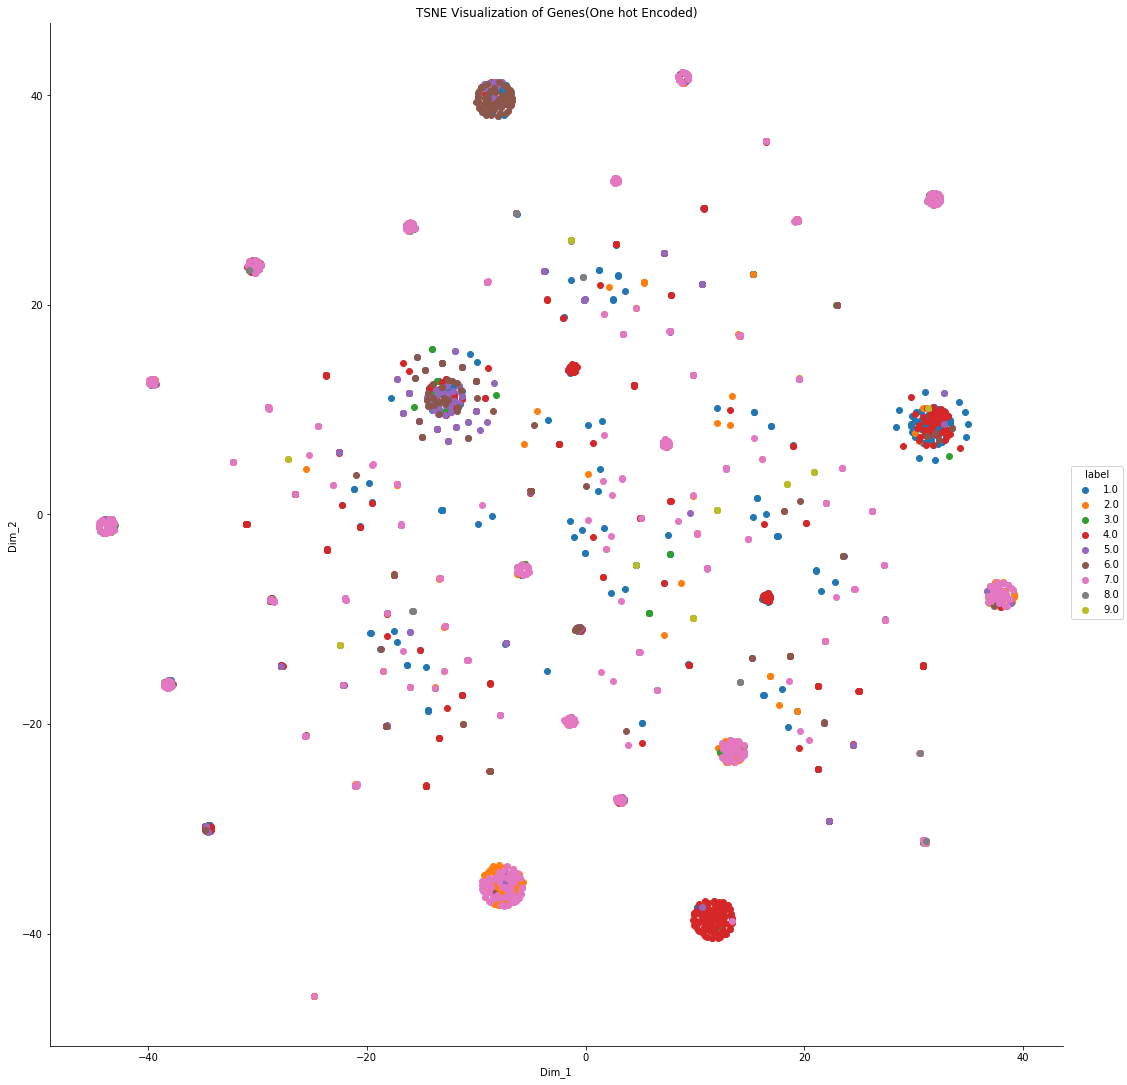

In [111]:
data_points = train_gene_feature_onehotCoding
top_1000 = data_points.toarray()
top_labels = y_train
model = TSNE(n_components=2,random_state=0)
tsne_data = model.fit_transform(top_1000)
tsne_data = np.vstack((tsne_data.T,top_labels.T)).T
tsne_df = pd.DataFrame(data=tsne_data,columns=('Dim_1','Dim_2','label'))
sns.FacetGrid(data=tsne_df,hue='label',size=15).map(plt.scatter,'Dim_1','Dim_2').add_legend()
plt.title('TSNE Visualization of Genes(One hot Encoded)')
plt.show()

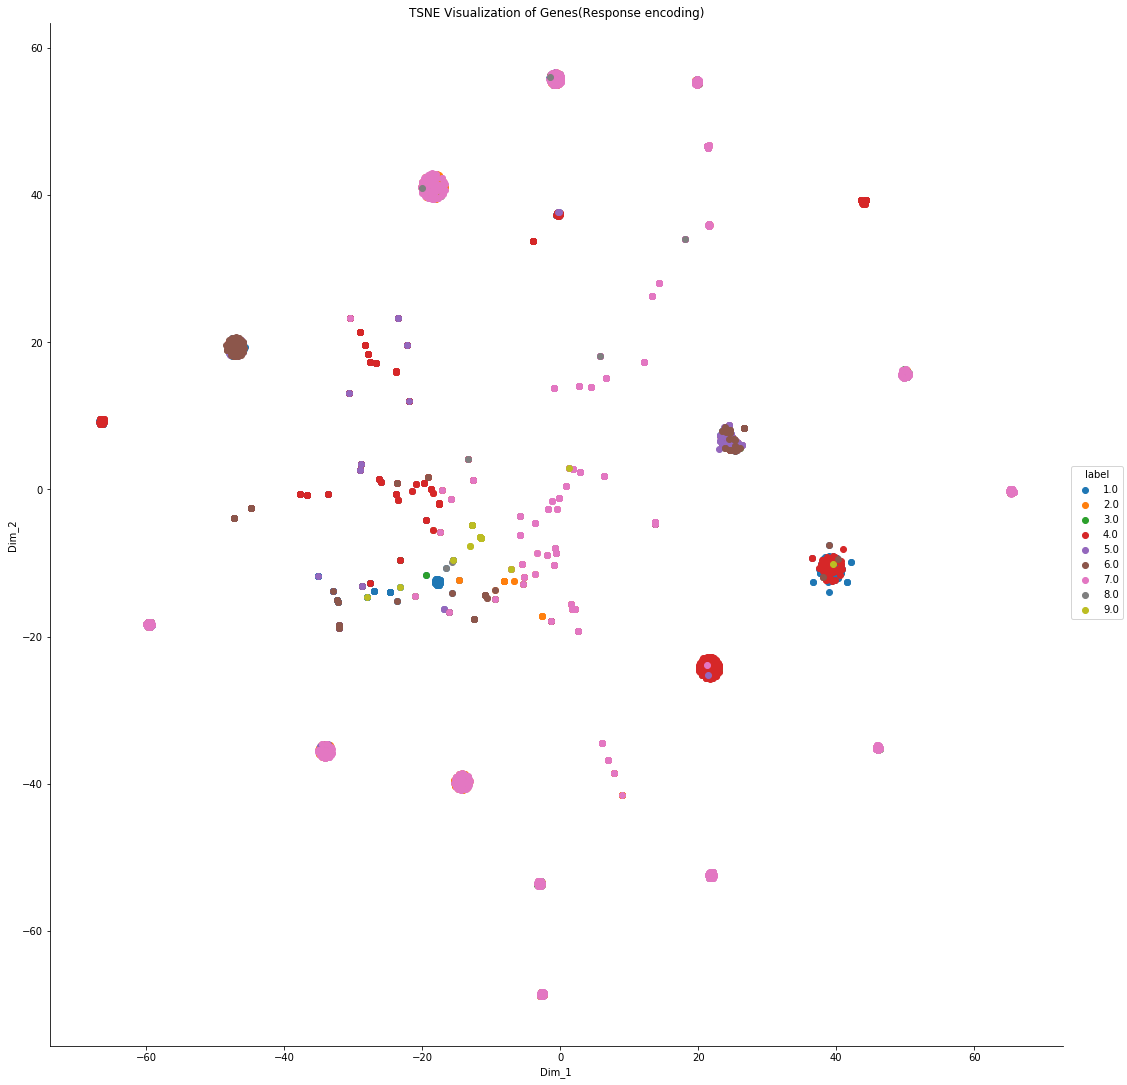

In [39]:
data_points = train_gene_feature_responseCoding
top_labels = y_train
model = TSNE(n_components=2,random_state=0)
tsne_data = model.fit_transform(data_points)
tsne_data = np.vstack((tsne_data.T,top_labels.T)).T
tsne_df = pd.DataFrame(data=tsne_data,columns=('Dim_1','Dim_2','label'))
sns.FacetGrid(data=tsne_df,hue='label',size=15).map(plt.scatter,'Dim_1','Dim_2').add_legend()
plt.title('TSNE Visualization of Genes(Response encoding)')
plt.show()

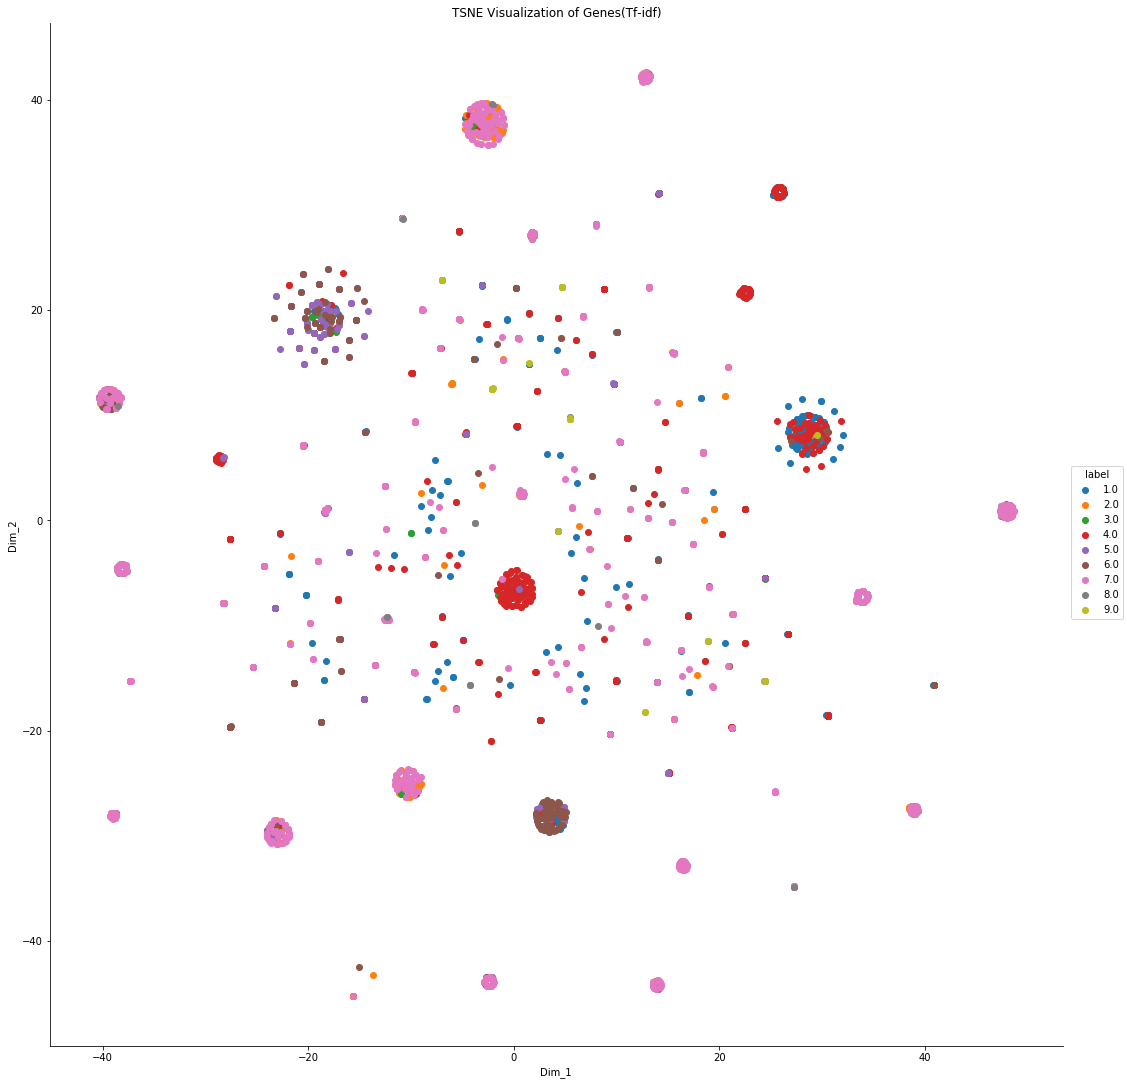

In [55]:
data_points = train_gene_tfidf.toarray()
top_labels = y_train
model = TSNE(n_components=2,random_state=0)
tsne_data = model.fit_transform(data_points)
tsne_data = np.vstack((tsne_data.T,top_labels.T)).T
tsne_df = pd.DataFrame(data=tsne_data,columns=('Dim_1','Dim_2','label'))
sns.FacetGrid(data=tsne_df,hue='label',size=15).map(plt.scatter,'Dim_1','Dim_2').add_legend()
plt.title('TSNE Visualization of Genes(Tf-idf)')
plt.show()

## Univariate analysis on Variation Feature

<p style="font-size:18px;"> <b>Q7.</b> Variation, What type of feature is it ?</p>
<p style="font-size:16px;"><b>Ans.</b> Variation is a categorical variable </p>
<p style="font-size:18px;"> <b>Q8.</b> How many categories are there?</p>

In [56]:
unique_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
# the top 10 variations that occured most
print(unique_variations.head(10))

Number of Unique Variations : 1924
Truncating_Mutations    57
Deletion                51
Amplification           46
Fusions                 21
Overexpression           6
T58I                     3
E17K                     3
Q61L                     3
G12V                     3
Q61R                     3
Name: Variation, dtype: int64


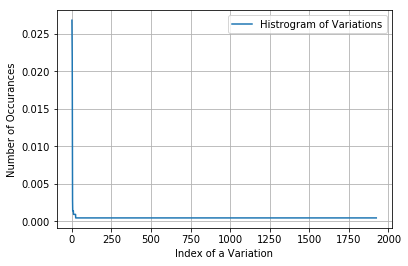

In [57]:
s = sum(unique_variations.values);
h = unique_variations.values/s;
plt.plot(h, label="Histrogram of Variations")
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

[0.02683616 0.05084746 0.07250471 ... 0.99905838 0.99952919 1.        ]


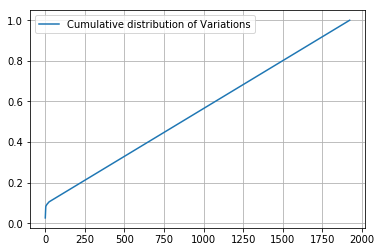

In [58]:
c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

We will be using three encoding techniques:
- One hot encoding
- Response Encoding
- Tf-idf

In [11]:
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

# unigrams and bigrams
variation_vectorizer_bigram = CountVectorizer(ngram_range=(1,2))
train_variation_feature_bigram = variation_vectorizer_bigram.fit_transform(train_df['Variation'])
test_variation_feature_bigram = variation_vectorizer_bigram.transform(test_df['Variation'])
cv_variation_feature_bigram = variation_vectorizer_bigram.transform(cv_df['Variation'])

# tfidf vectorized
tfidf_vect = TfidfVectorizer()
train_variation_feature_tfidf = tfidf_vect.fit_transform(train_df['Variation'])
test_variation_feature_tfidf = tfidf_vect.transform(test_df['Variation'])
cv_variation_feature_tfidf = tfidf_vect.transform(cv_df['Variation'])

In [60]:
print("train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature:", train_variation_feature_responseCoding.shape)

train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature: (2124, 9)


In [16]:
print("train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature:", train_variation_feature_onehotCoding.shape)

train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature: (2124, 1967)


In [17]:
print("train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature:", train_variation_feature_tfidf.shape)

train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature: (2124, 1967)


In [15]:
print("train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature:", train_variation_feature_bigram.shape)

train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature: (2124, 2066)


### How good is variation feature in classification ?


For values of alpha =  1e-05 The log loss is: 1.692893434387574
For values of alpha =  0.0001 The log loss is: 1.6749375684108374
For values of alpha =  0.001 The log loss is: 1.6746547880917584
For values of alpha =  0.01 The log loss is: 1.6839104736999984
For values of alpha =  0.1 The log loss is: 1.6967956381603253
For values of alpha =  1 The log loss is: 1.6973825099533326


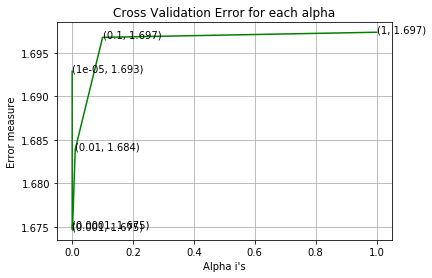

For values of best alpha =  0.001 The train log loss is: 1.0925520712065606
For values of best alpha =  0.001 The cross validation log loss is: 1.6746547880917584
For values of best alpha =  0.001 The test log loss is: 1.7086636363180554


In [64]:
######### Variation one hot encoding   ##########
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of alpha =  1e-05 The log loss is: 2.0221079071140133
For values of alpha =  0.0001 The log loss is: 1.851430018892176
For values of alpha =  0.001 The log loss is: 1.8403821500715531
For values of alpha =  0.01 The log loss is: 1.8331749633083172
For values of alpha =  0.1 The log loss is: 1.8309275452752185
For values of alpha =  1 The log loss is: 1.813294402812133


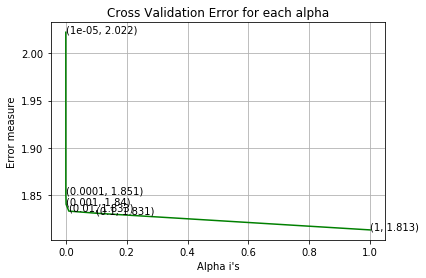

For values of best alpha =  1 The train log loss is: 1.0395876800607127
For values of best alpha =  1 The cross validation log loss is: 1.813294402812133
For values of best alpha =  1 The test log loss is: 1.8294417896018207


In [68]:
############    Variation response encoding   ############
alpha = [10 ** x for x in range(-5, 1)]




cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42,max_iter=30)
    clf.fit(train_variation_feature_responseCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_responseCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_responseCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42,max_iter=30)
clf.fit(train_variation_feature_responseCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_responseCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


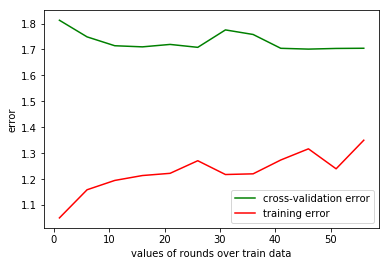

In [70]:
cv_error = []
train_error =[]
for i in range(1,60,5):
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42,max_iter=i)
    clf.fit(train_variation_feature_responseCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_responseCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_responseCoding)
    predict_y_train = sig_clf.predict_proba(train_variation_feature_responseCoding)
    cv_error.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    train_error.append(log_loss(y_train, predict_y_train, labels=clf.classes_, eps=1e-15))
    #print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
fig, ax = plt.subplots()
ax.plot(range(1,60,5), cv_error,c='g',label='cross-validation error')
ax.plot(range(1,60,5),train_error,c='r',label='training error')
plt.xlabel('values of rounds over train data')
plt.ylabel('error')
plt.plot()
plt.legend()
plt.show()

<p style="font-size:18px;"> <b>Q11.</b> Is the Variation feature stable across all the data sets (Test, Train, Cross validation)?</p>
<p style="font-size:16px;"> <b>Ans.</b> Not sure! But lets be very sure using the below analysis. </p>

In [71]:
print("Q12. How many data points are covered by total ", unique_variations.shape[0], " genes in test and cross validation data sets?")
test_coverage=test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage=cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Q12. How many data points are covered by total  1924  genes in test and cross validation data sets?
Ans
1. In test data 51 out of 665 : 7.669172932330827
2. In cross validation data 65 out of  532 : 12.218045112781954


<h3>Univariate Analysis on Text Feature</h3>

1. How many unique words are present in train data?
2. How are word frequencies distributed?
3. How to featurize text field?
4. Is the text feature useful in predicitng y_i?
5. Is the text feature stable across train, test and CV datasets?

In [12]:
# cls_text is a data frame
# for every row in data frame consider the 'TEXT'
# split the words by space
# make a dict with those words
# increment its count whenever we see that word

def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['Text'].split():
            dictionary[word] +=1
    return dictionary

In [13]:
import math
#https://stackoverflow.com/a/1602964
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['Text'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['Text'].split()))
            row_index += 1
    return text_feature_responseCoding

In [15]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [14]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['Text'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 52708


In [16]:
#normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['Text'])
#normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['Text'])
# normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [17]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [18]:
# https://stackoverflow.com/a/16202486
# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [19]:
#  tfidf vectorization
tfidf_text_vect = TfidfVectorizer(ngram_range=(1,2))
train_text_vect = tfidf_text_vect[].fit_transform(train_df['Text'])
cross_val_text_vect = tfidf_text_vect.transform(cv_df['Text'])
test_text_vect = tfidf_text_vect.transform(test_df['Text'])

In [20]:
#  unigrams and bigrams
text_vectorizer_bigram = CountVectorizer(ngram_range=(1,2))
train_text_feature_bigram = normalize(text_vectorizer_bigram.fit_transform(train_df['Text']))
test_text_feature_bigram = normalize(text_vectorizer_bigram.transform(test_df['Text']))
cv_text_feature_bigram = normalize(text_vectorizer_bigram.transform(cv_df['Text']))

In [21]:
#https://stackoverflow.com/a/2258273/4084039
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [90]:
# Number of words for a given frequency.
print(Counter(sorted_text_occur))

Counter({3: 5290, 4: 3884, 5: 2716, 6: 2539, 8: 2022, 7: 1974, 10: 1813, 9: 1710, 12: 1280, 14: 1179, 11: 1048, 15: 941, 13: 850, 16: 797, 18: 720, 17: 600, 20: 575, 19: 507, 21: 485, 24: 449, 23: 440, 25: 434, 22: 434, 27: 398, 28: 374, 26: 364, 39: 358, 51: 327, 30: 318, 34: 302, 36: 297, 29: 292, 32: 277, 33: 254, 40: 252, 35: 250, 31: 240, 37: 220, 38: 210, 42: 207, 41: 205, 44: 191, 48: 183, 46: 176, 45: 167, 54: 163, 50: 162, 49: 158, 56: 155, 43: 155, 52: 148, 57: 140, 55: 140, 47: 138, 53: 132, 60: 129, 68: 115, 80: 108, 72: 107, 62: 105, 69: 104, 59: 103, 61: 102, 65: 100, 63: 100, 84: 99, 73: 98, 70: 97, 64: 97, 66: 96, 58: 95, 79: 87, 76: 83, 67: 82, 87: 81, 75: 81, 77: 80, 85: 74, 81: 74, 71: 74, 90: 73, 78: 71, 102: 70, 94: 68, 82: 67, 74: 67, 86: 66, 103: 65, 98: 64, 96: 64, 88: 64, 83: 62, 144: 60, 93: 58, 99: 57, 92: 57, 89: 55, 100: 54, 110: 53, 91: 53, 120: 52, 105: 52, 134: 51, 114: 51, 124: 50, 112: 50, 111: 50, 104: 50, 125: 48, 107: 48, 101: 48, 108: 47, 106: 47, 

For values of alpha =  1e-05 The log loss is: 1.3718438623399405
For values of alpha =  0.0001 The log loss is: 1.3048617803455933
For values of alpha =  0.001 The log loss is: 1.1947130900582172
For values of alpha =  0.01 The log loss is: 1.2446461350415736
For values of alpha =  0.1 The log loss is: 1.376816744847818
For values of alpha =  1 The log loss is: 1.6094376556269787


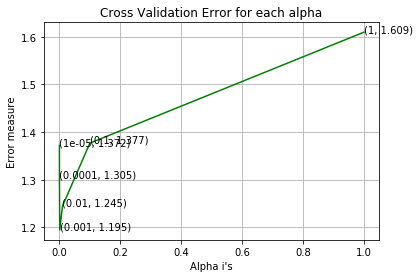

For values of best alpha =  0.001 The train log loss is: 0.7498921088110815
For values of best alpha =  0.001 The cross validation log loss is: 1.1947130900582172
For values of best alpha =  0.001 The test log loss is: 1.1752470226313543


In [91]:
# Train a Logistic regression+Calibration model using text features whicha re on-hot encoded
alpha = [10 ** x for x in range(-5, 1)]

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of alpha =  1e-05 The log loss is: 1.117016217246626
For values of alpha =  0.0001 The log loss is: 1.0176583197626694
For values of alpha =  0.001 The log loss is: 1.0913440587880037
For values of alpha =  0.01 The log loss is: 1.2935819483972608
For values of alpha =  0.1 The log loss is: 1.5081092813926653
For values of alpha =  1 The log loss is: 1.5716353534011631


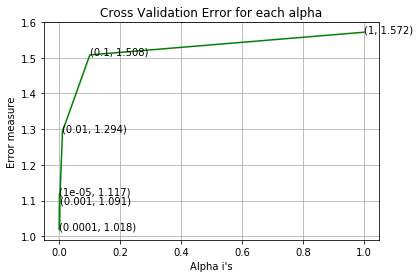

For values of best alpha =  0.0001 The train log loss is: 0.654137584847539
For values of best alpha =  0.0001 The cross validation log loss is: 1.0176583197626694
For values of best alpha =  0.0001 The test log loss is: 1.0660601284290219


In [98]:
# Train a Logistic regression+Calibration model using text features whicha re on-hot encoded
alpha = [10 ** x for x in range(-5, 1)]

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.


cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_vect, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_vect, y_train)
    predict_y = sig_clf.predict_proba(cross_val_text_vect)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_vect, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_vect, y_train)

predict_y = sig_clf.predict_proba(train_text_vect)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cross_val_text_vect)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_vect)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


<p style="font-size:18px;"> <b>Q.</b> Is the Text feature stable across all the data sets (Test, Train, Cross validation)?</p>
<p style="font-size:16px;"> <b>Ans.</b> Yes, it seems like! </p>

In [106]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['Text'])
    df_text_features = df_text_vec.get_feature_names()
    #print(df_text_features)
    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    print(df_text_fea_counts.shape)
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [107]:
len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

(28121,)
97.344 % of word of test data appeared in train data
(25174,)
98.681 % of word of Cross Validation appeared in train data


<h1>Machine Learning Models</h1>

In [21]:
#Data preparation for ML models.

#Misc. functionns for ML models


def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [22]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [23]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['Text'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            print(v)
            print('len of text vect',len(text_vec.get_feature_names()))
            print(fea1_len+fea2_len)
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")
    
    
    
def get_impfeature_names_tfidf(indices, text, gene, var, no_features):
    gene_count_vec_tfidf = TfidfVectorizer(ngram_range=(1,2))
    var_count_vec_tfidf = TfidfVectorizer(ngram_range=(1,2))
    text_count_vec_tfidf = TfidfVectorizer(ngram_range=(1,2))
    
    gene_vec_tfidf = gene_count_vec_tfidf.fit(train_df['Gene'])
    var_vec_tfidf  = var_count_vec_tfidf.fit(train_df['Variation'])
    text_vec_tfidf = text_count_vec_tfidf.fit(train_df['Text'])
    
    fea1_len = len(gene_vec_tfidf.get_feature_names())
    fea2_len = len(var_count_vec_tfidf.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec_tfidf.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec_tfidf.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            #print(v)
            #print('len of text vect',len(text_vec_tfidf.get_feature_names()))
            #print(fea1_len+fea2_len)
            word = text_vec_tfidf.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")
    
def get_impfeature_names_bigram(indices, text, gene, var, no_features):
    gene_count_vec_bigram = CountVectorizer(ngram_range=(1,2))
    var_count_vec_bigram = CountVectorizer(ngram_range=(1,2))
    text_count_vec_bigram = CountVectorizer(ngram_range=(1,2))
    
    gene_vec = gene_count_vec_bigram.fit(train_df['Gene'])
    var_vec  = var_count_vec_bigram.fit(train_df['Variation'])
    text_vec = text_count_vec_bigram.fit(train_df['Text'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            #print(v)
            #print('len of text vect',len(text_vec.get_feature_names()))
            #print(fea1_len+fea2_len)
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

### Stacking Up data frames

In [24]:
###   One hot encoding   ###

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()

###  Response Coding  ###

train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))

###  Tfidf ###

train_gene_var_tfidf = hstack((train_gene_tfidf,train_variation_feature_tfidf))
test_gene_var_tfidf = hstack((test_gene_tfidf,test_variation_feature_tfidf))
cv_gene_var_tfidf = hstack((cv_gene_tfidf,cv_variation_feature_tfidf))

train_x_tfidf = hstack((train_gene_var_tfidf,train_text_vect)).tocsr()
test_x_tfidf = hstack((test_gene_var_tfidf,test_text_vect)).tocsr()
cv_x_tfidf = hstack((cv_gene_var_tfidf,cross_val_text_vect)).tocsr()

###  Unigrams and bigrams   ####

train_gene_var_bigram = hstack((train_gene_feature_bigram,train_variation_feature_bigram))
test_gene_var_bigram = hstack((test_gene_feature_bigram,test_variation_feature_bigram))
cv_gene_var_bigram = hstack((cv_gene_feature_bigram,cv_variation_feature_bigram))

train_x_bigram = hstack((train_gene_var_bigram, train_text_feature_bigram)).tocsr()
test_x_bigram = hstack((test_gene_var_bigram, test_text_feature_bigram)).tocsr()
cv_x_bigram = hstack((cv_gene_var_bigram, cv_text_feature_bigram)).tocsr()


train_y = np.array(list(train_df['Class']))
test_y = np.array(list(test_df['Class']))
cv_y = np.array(list(cv_df['Class']))

#train_x_tfidf = train_x_tfidf.T

In [1]:
# source: https://buhrmann.github.io/tfidf-analysis.html
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df
def top_tfidf(data):
    top_tfidf_1000 = []
    len = (data.shape[0])
    print(len)
    for i in range(0,len):
        top_tfidf = top_tfidf_feats(data[i,:].toarray()[0],features=features,top_n=1000)
        top_tfidf.drop(labels='feature',inplace=True,axis=1)
        top_tfidf.sort_values('tfidf',kind='quicksort',ascending=False)
        top_tfidf = top_tfidf.as_matrix()
        #print(top_tfidf.shape)
        top_tfidf_1000.append(top_tfidf)
        #print(top_tfidf_1000[0].shape)
    return np.array(top_tfidf_1000)

In [162]:
train_x_tfidf_1000 = top_tfidf(data=train_text_vect)
train_x_tfidf_1000.reshape(2124,1000)
cv_x_tfidf_1000 = top_tfidf(data=cross_val_text_vect)
cv_x_tfidf_1000.reshape(532,1000)

test_x_tfidf_1000 = top_tfidf(data=test_text_vect)
test_x_tfidf_1000.reshape(665,1000)


2124
532
665


array([[0.32986497, 0.29205178, 0.25147676, ..., 0.00783335, 0.00783335,
        0.00783335],
       [0.7077165 , 0.28738452, 0.22203935, ..., 0.00505006, 0.00504085,
        0.00503689],
       [0.59851635, 0.38705498, 0.17552011, ..., 0.00888817, 0.00888817,
        0.00888817],
       ...,
       [0.51154504, 0.32471661, 0.28989825, ..., 0.00944666, 0.00944666,
        0.00944666],
       [0.55794576, 0.32989282, 0.24814744, ..., 0.00921401, 0.00921401,
        0.00921401],
       [0.50806781, 0.33077812, 0.24824101, ..., 0.00711072, 0.00711072,
        0.00711072]])

In [168]:
###   One hot encoding   ###

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()

###  Response Coding  ###

train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))

###  Tfidf ###

train_gene_var_tfidf = hstack((train_gene_tfidf,train_variation_feature_tfidf))
test_gene_var_tfidf = hstack((test_gene_tfidf,test_variation_feature_tfidf))
cv_gene_var_tfidf = hstack((cv_gene_tfidf,cv_variation_feature_tfidf))

train_x_tfidf_1000 = hstack((train_gene_var_tfidf,train_x_tfidf_1000)).tocsr()
test_x_tfidf_1000 = hstack((test_gene_var_tfidf,test_x_tfidf_1000)).tocsr()
cv_x_tfidf_1000 = hstack((cv_gene_var_tfidf,cv_x_tfidf_1000)).tocsr()

###  Unigrams and bigrams   ####

train_gene_var_bigram = hstack((train_gene_feature_bigram,train_variation_feature_bigram))
test_gene_var_bigram = hstack((test_gene_feature_bigram,test_variation_feature_bigram))
cv_gene_var_bigram = hstack((cv_gene_feature_bigram,cv_variation_feature_bigram))

train_x_bigram = hstack((train_gene_var_bigram, train_text_feature_bigram))
test_x_bigram = hstack((test_gene_var_bigram, test_text_feature_bigram))
cv_x_bigram = hstack((cv_gene_var_bigram, cv_text_feature_bigram))


train_y = np.array(list(train_df['Class']))
test_y = np.array(list(test_df['Class']))
cv_y = np.array(list(cv_df['Class']))

#train_x_tfidf = train_x_tfidf.T

In [34]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 54635)
(number of data points * number of features) in test data =  (665, 54635)
(number of data points * number of features) in cross validation data = (532, 54635)


In [35]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


In [36]:
print(" tfidf encoding features :")
print("(number of data points * number of features) in train data = ", train_x_tfidf.shape)
print("(number of data points * number of features) in test data = ", test_x_tfidf.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_tfidf.shape)

 tfidf encoding features :
(number of data points * number of features) in train data =  (2124, 2363201)
(number of data points * number of features) in test data =  (665, 2363201)
(number of data points * number of features) in cross validation data = (532, 2363201)


In [37]:
print(" tfidf encoding features :")
print("(number of data points * number of features) in train data = ", train_x_bigram.shape)
print("(number of data points * number of features) in test data = ", test_x_bigram.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_bigram.shape)

 tfidf encoding features :
(number of data points * number of features) in train data =  (2124, 2363300)
(number of data points * number of features) in test data =  (665, 2363300)
(number of data points * number of features) in cross validation data = (532, 2363300)


<h2>Base Line Model</h2>

<h3>Naive Bayes</h3>

for alpha = 1e-05
Log Loss : 1.2864287807461874
for alpha = 0.0001
Log Loss : 1.28101175039053
for alpha = 0.001
Log Loss : 1.2704760920697649
for alpha = 0.1
Log Loss : 1.2753892779773042
for alpha = 1
Log Loss : 1.2808397053515208
for alpha = 10
Log Loss : 1.4050209930916733
for alpha = 100
Log Loss : 1.37475957537318
for alpha = 1000
Log Loss : 1.2875062907460366


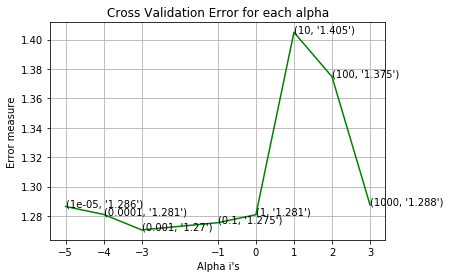

For values of best alpha =  0.001 The train log loss is: 0.8792277428943698
For values of best alpha =  0.001 The cross validation log loss is: 1.2704760920697649
For values of best alpha =  0.001 The test log loss is: 1.2849099955365675


In [114]:
###  One hot encoding  ###
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


for alpha = 1e-05
Log Loss : 1.2073330199224586
for alpha = 0.0001
Log Loss : 1.2073325663912502
for alpha = 0.001
Log Loss : 1.2073280616395246
for alpha = 0.1
Log Loss : 1.2069977243377488
for alpha = 1
Log Loss : 1.2091895432552697
for alpha = 10
Log Loss : 1.2651639388413491
for alpha = 100
Log Loss : 1.2650563119308755
for alpha = 1000
Log Loss : 1.2606306681452648


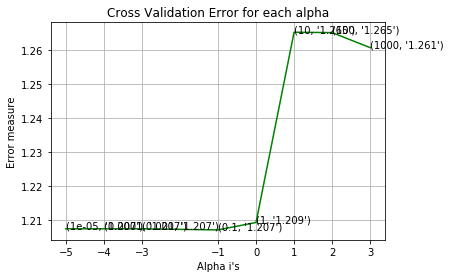

For values of best alpha =  0.1 The train log loss is: 1.1927534153812267
For values of best alpha =  0.1 The cross validation log loss is: 1.2069977243377488
For values of best alpha =  0.1 The test log loss is: 1.2655156458047734


In [166]:
###    Response Coding   ###
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


for alpha = 1e-05
Log Loss : 1.2159993847344577
for alpha = 0.0001
Log Loss : 1.214086885634955
for alpha = 0.001
Log Loss : 1.2108720699642417
for alpha = 0.1
Log Loss : 1.2272288771992952
for alpha = 1
Log Loss : 1.1749533696521304
for alpha = 10
Log Loss : 1.1859413092481403
for alpha = 100
Log Loss : 1.2352319493877786
for alpha = 1000
Log Loss : 1.2456314048217818


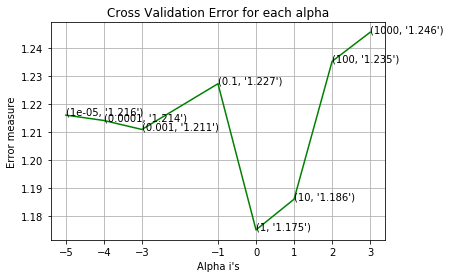

For values of best alpha =  1 The train log loss is: 1.0273076846652764
For values of best alpha =  1 The cross validation log loss is: 1.1749533696521304
For values of best alpha =  1 The test log loss is: 1.2362226014268294


In [177]:
####   tfidf   ###
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_tfidf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)


predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


In [172]:

###  naive bayes using tfidf  ###
clf = MultinomialNB(alpha=1)
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)
test_point_index = 4 #np.random.randint(1,test_x_tfidf.shape[0])
no_feature = 500
predicted_cls = sig_clf.predict(test_x_tfidf[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_tfidf[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names_tfidf(indices[0], test_df['Text'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0324 0.1008 0.0278 0.0284 0.0507 0.0455 0.6968 0.0061 0.0116]]
Actual Class : 7
--------------------------------------------------
337 Text feature [000] present in test data point [True]
Out of the top  500  features  1 are present in query point


for alpha = 1e-05
Log Loss : 1.2886533944160607
for alpha = 0.0001
Log Loss : 1.288018842592092
for alpha = 0.001
Log Loss : 1.2855956087409233
for alpha = 0.1
Log Loss : 1.2845288945992406
for alpha = 1
Log Loss : 1.3579550978202413
for alpha = 10
Log Loss : 1.4577478094640075
for alpha = 100
Log Loss : 1.4287543052015332
for alpha = 1000
Log Loss : 1.4239826385529373


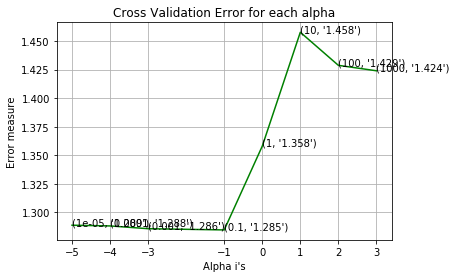

For values of best alpha =  0.1 The train log loss is: 0.5207447174923271
For values of best alpha =  0.1 The cross validation log loss is: 1.2845288945992406
For values of best alpha =  0.1 The test log loss is: 1.2542278980550603


In [169]:
###   tfidf_top_1000   ####
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_tfidf_1000, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf_1000, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf_1000)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_tfidf_1000, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf_1000, train_y)


predict_y = sig_clf.predict_proba(train_x_tfidf_1000)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidf_1000)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidf_1000)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


for alpha = 1e-05
Log Loss : 1.1817002377674433
for alpha = 0.0001
Log Loss : 1.182110607266526
for alpha = 0.001
Log Loss : 1.1775464070909933
for alpha = 0.1
Log Loss : 1.3269616170681298
for alpha = 1
Log Loss : 1.349987768455535
for alpha = 10
Log Loss : 1.2944808128127698
for alpha = 100
Log Loss : 1.2884920457461433
for alpha = 1000
Log Loss : 1.2943526108282883


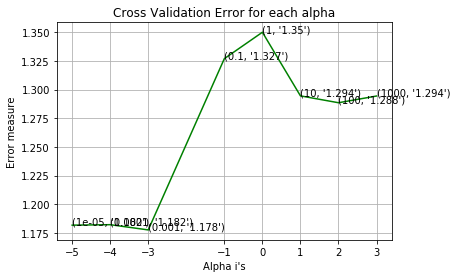

For values of best alpha =  0.001 The train log loss is: 0.7198141842652124
For values of best alpha =  0.001 The cross validation log loss is: 1.1775464070909933
For values of best alpha =  0.001 The test log loss is: 1.2136274938708833


In [178]:
### unigrams and bigrams  ###
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_bigram, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_bigram, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_bigram)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_bigram, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_bigram, train_y)


predict_y = sig_clf.predict_proba(train_x_bigram)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_bigram)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_bigram)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


### Testing model with best hyper parameters

Log Loss : 1.352518265550999
Number of missclassified point : 0.42857142857142855
-------------------- Confusion matrix C --------------------


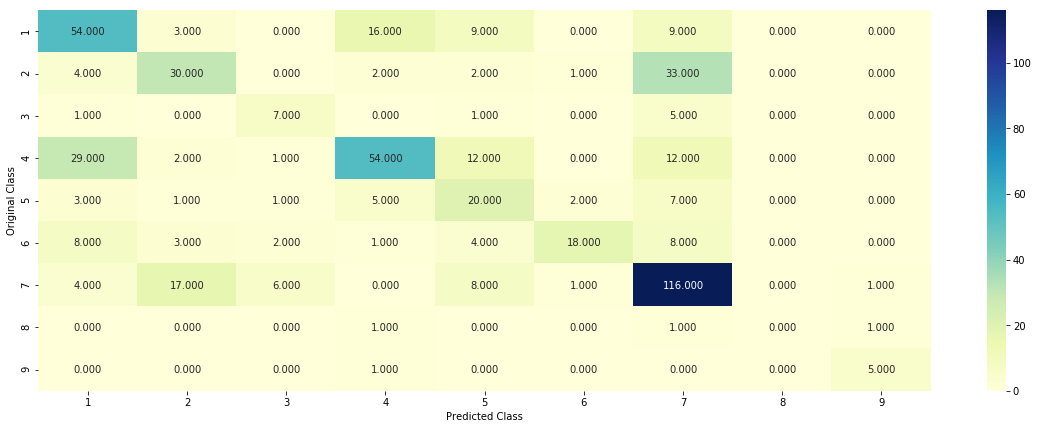

-------------------- Precision matrix (Columm Sum=1) --------------------


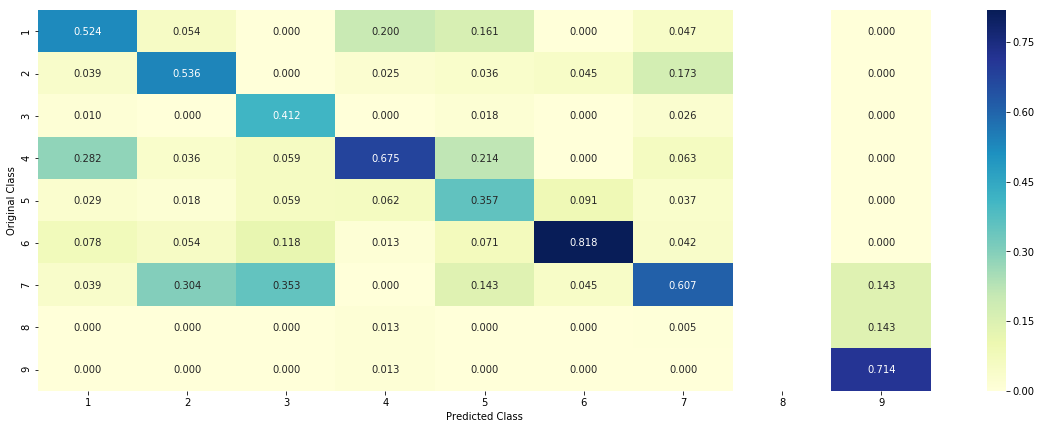

-------------------- Recall matrix (Row sum=1) --------------------


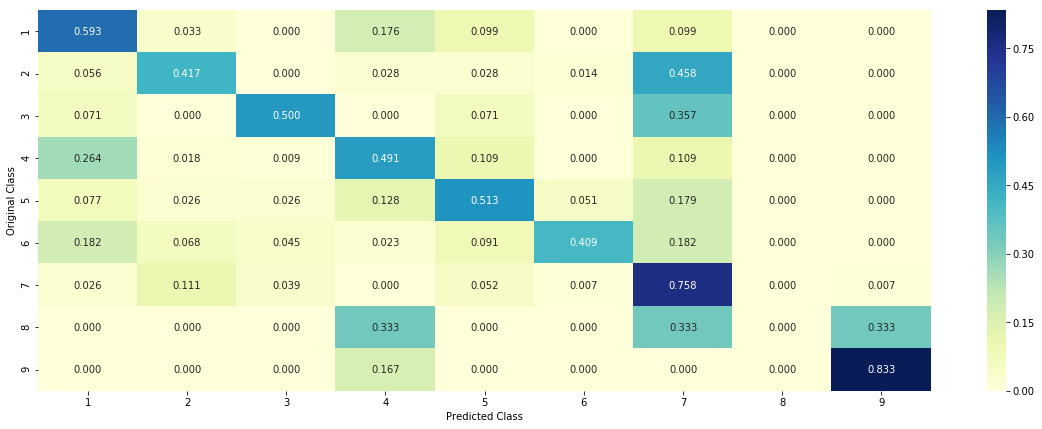

In [53]:
###   Naive bayes using one hot encoding ###
clf = MultinomialNB(alpha=0.001)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

In [59]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['Text'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0881 0.0829 0.0094 0.1115 0.0359 0.0345 0.6298 0.0051 0.0029]]
Actual Class : 2
--------------------------------------------------
18 Text feature [activating] present in test data point [True]
19 Text feature [downstream] present in test data point [True]
20 Text feature [presence] present in test data point [True]
22 Text feature [kinase] present in test data point [True]
23 Text feature [recently] present in test data point [True]
24 Text feature [shown] present in test data point [True]
25 Text feature [cell] present in test data point [True]
26 Text feature [factor] present in test data point [True]
27 Text feature [independent] present in test data point [True]
28 Text feature [well] present in test data point [True]
29 Text feature [expressing] present in test data point [True]
30 Text feature [cells] present in test data point [True]
31 Text feature [contrast] present in test data point [True]
32 Text feature [found] presen

Log Loss : 1.3135898203772602
Number of missclassified point : 0.4718045112781955
-------------------- Confusion matrix C --------------------


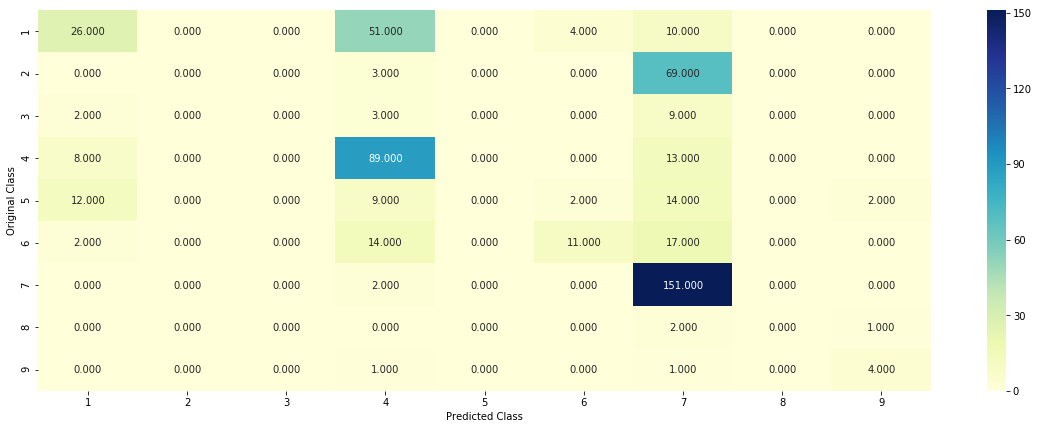

-------------------- Precision matrix (Columm Sum=1) --------------------


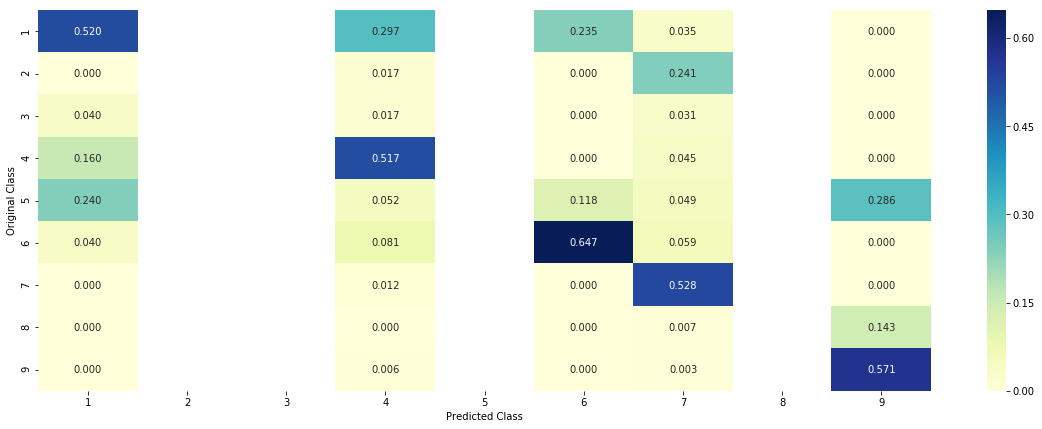

-------------------- Recall matrix (Row sum=1) --------------------


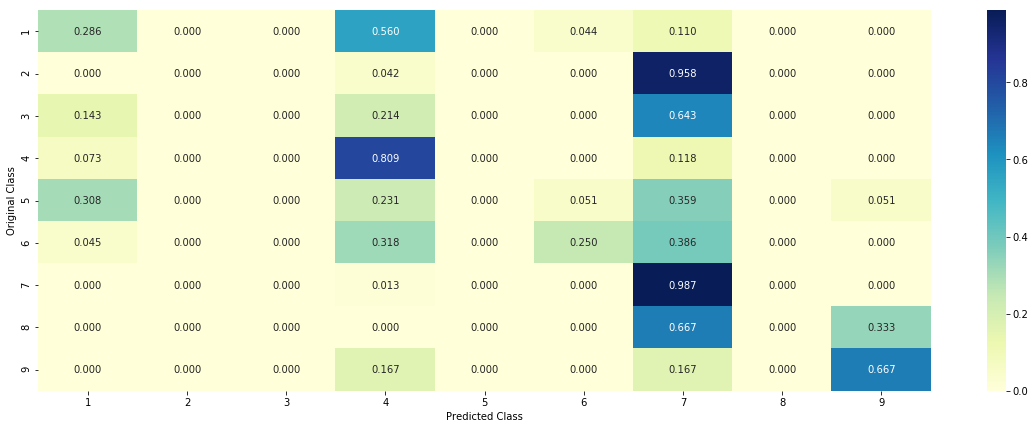

In [75]:
###  Naive bayes using Response encoding ###

clf = MultinomialNB(alpha=0.1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_responseCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_responseCoding))

In [79]:
test_point_index = np.random.randint(1,test_x_responseCoding.shape[1])
no_feature = 100
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['Text'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 9
Predicted Class Probabilities: [[0.1326 0.0725 0.0317 0.2409 0.0574 0.0573 0.1371 0.0174 0.2531]]
Actual Class : 5
--------------------------------------------------
Out of the top  100  features  0 are present in query point


Log Loss : 1.2836788842856952
 Confusion matrix C --------------------


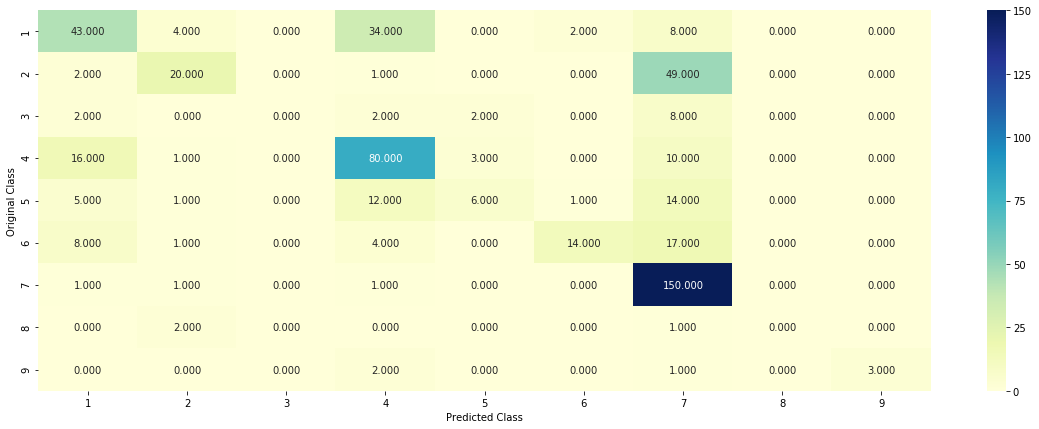

-------------------- Precision matrix (Columm Sum=1) --------------------


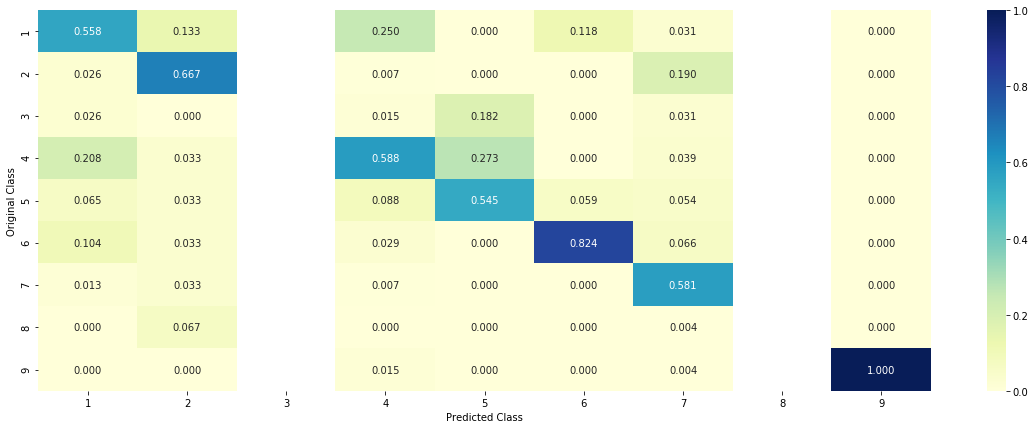

-------------------- Recall matrix (Row sum=1) --------------------


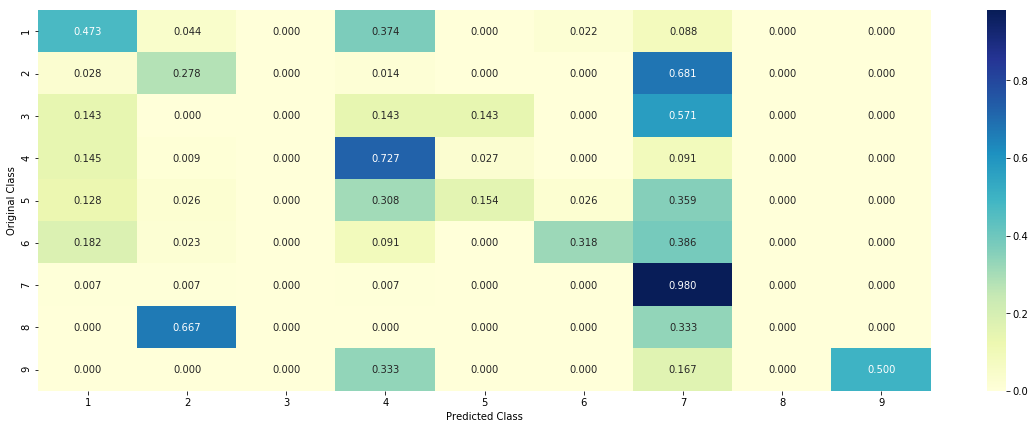

In [ ]:
###  naive bayes using tfidf  ###
clf = MultinomialNB(alpha=1)
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
#print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_tfidf[0:300])- cv_y[0:300]))/cv_y[0:300].shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_tfidf.toarray()))

In [29]:

###  naive bayes using tfidf  ###
clf = MultinomialNB(alpha=1)
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)
test_point_index = 1  #np.random.randint(1,test_x_tfidf.shape[0])
no_feature = 100
predicted_cls = sig_clf.predict(test_x_tfidf[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_tfidf[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names_tfidf(indices[0], test_df['Text'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.2828 0.1609 0.0394 0.2813 0.0905 0.0784 0.0482 0.0079 0.0106]]
Actual Class : 4
--------------------------------------------------
Out of the top  100  features  0 are present in query point


Log Loss : 1.1501301507388777
Number of missclassified point : 0.3308270676691729
-------------------- Confusion matrix C --------------------


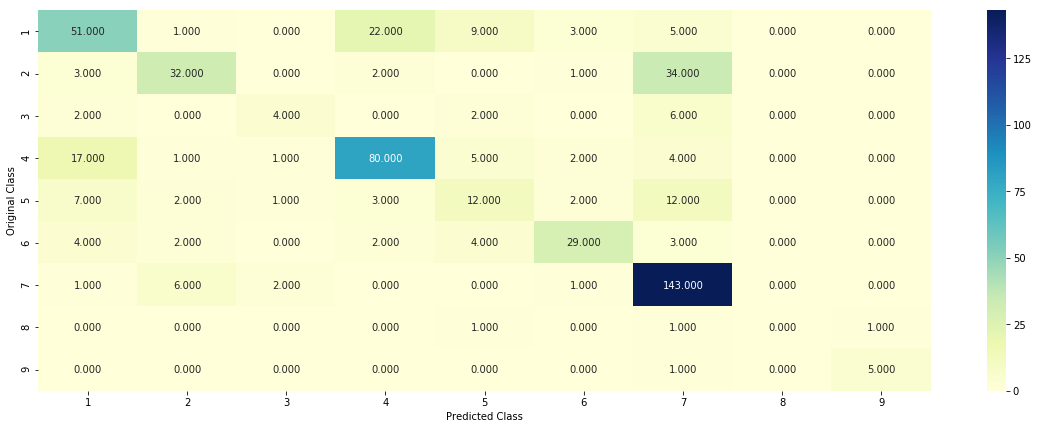

-------------------- Precision matrix (Columm Sum=1) --------------------


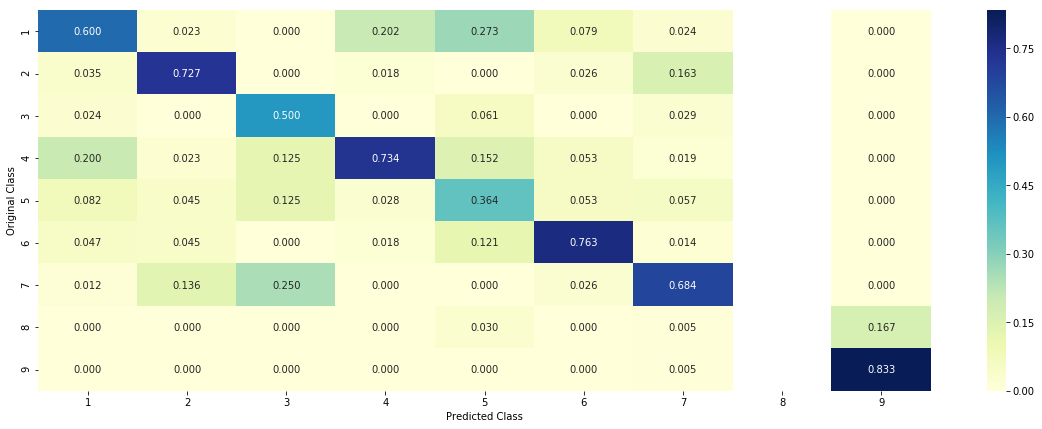

-------------------- Recall matrix (Row sum=1) --------------------


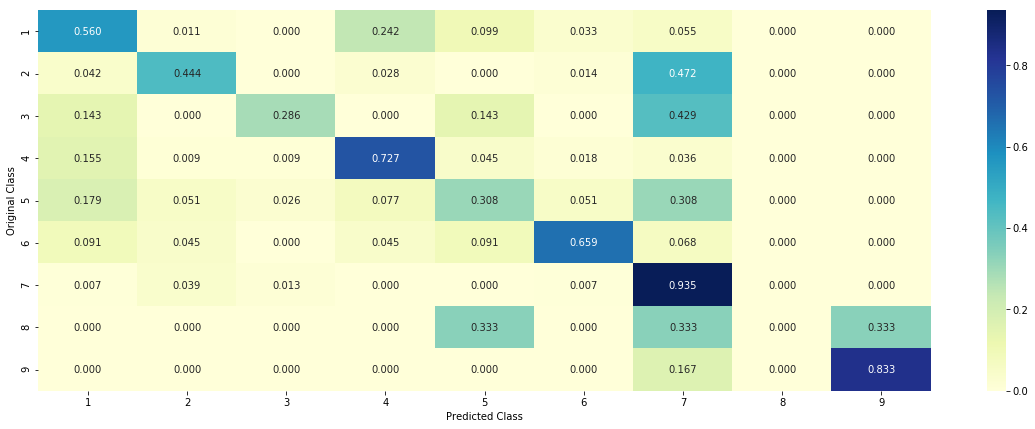

In [ ]:
###  naive bayes using bigram  ###
clf = MultinomialNB(alpha=0.001)
clf.fit(train_x_bigram, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_bigram, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_bigram)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_bigram)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_bigram.toarray()))

In [30]:
clf = MultinomialNB(alpha=0.001)
clf.fit(train_x_bigram, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_bigram, train_y)
test_point_index = 5  #np.random.randint(1,test_x_tfidf.shape[0])
no_feature = 200
predicted_cls = sig_clf.predict(test_x_bigram[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_bigram[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names_bigram(indices[0], test_df['Text'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.2504 0.0636 0.0125 0.5041 0.0459 0.0328 0.0818 0.0042 0.0047]]
Actual Class : 4
--------------------------------------------------
0 Text feature [mutations] present in test data point [True]
3 Text feature [cells] present in test data point [True]
5 Text feature [protein] present in test data point [True]
6 Text feature [activity] present in test data point [True]
7 Text feature [fig] present in test data point [True]
8 Text feature [cell] present in test data point [True]
10 Text feature [mutation] present in test data point [True]
11 Text feature [figure] present in test data point [True]
16 Text feature [type] present in test data point [True]
18 Text feature [cancer] present in test data point [True]
20 Text feature [mutant] present in test data point [True]
21 Text feature [mutants] present in test data point [True]
22 Text feature [binding] present in test data point [True]
23 Text feature [expression] present in test data p

## KNN

for alpha = 1
Log Loss : 1.3448739589510996
for alpha = 2
Log Loss : 1.322489357233288
for alpha = 3
Log Loss : 1.2712327078552699
for alpha = 4
Log Loss : 1.268123441137996
for alpha = 5
Log Loss : 1.3056715316187395
for alpha = 11
Log Loss : 1.336212350009167
for alpha = 15
Log Loss : 1.3617898766535703
for alpha = 21
Log Loss : 1.4129809994472668
for alpha = 31
Log Loss : 1.4284899993094766
for alpha = 41
Log Loss : 1.4250982970630062
for alpha = 51
Log Loss : 1.3876341373898922
for alpha = 99
Log Loss : 1.4733858062060639


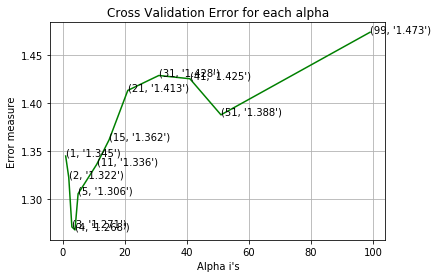

For values of best alpha =  4 The train log loss is: 0.9502097515006538
For values of best alpha =  4 The cross validation log loss is: 1.268123441137996
For values of best alpha =  4 The test log loss is: 1.2686437861327058


In [68]:
###    One hot encoding  ###
alpha = [1,2,3,4,5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


for alpha = 1
Log Loss : 1.2650506404207562
for alpha = 2
Log Loss : 1.1212466852725889
for alpha = 3
Log Loss : 1.0913202992758249
for alpha = 4
Log Loss : 1.0519298606101477
for alpha = 5
Log Loss : 1.0433930462105832
for alpha = 11
Log Loss : 1.0750685900222479
for alpha = 15
Log Loss : 1.0903680719010813
for alpha = 21
Log Loss : 1.108737908429046
for alpha = 31
Log Loss : 1.1288874019542672
for alpha = 41
Log Loss : 1.1486460903543634
for alpha = 51
Log Loss : 1.1491410860528892
for alpha = 99
Log Loss : 1.1516203121203972


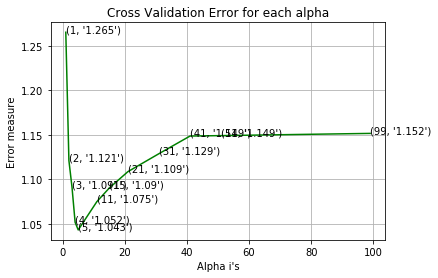

For values of best alpha =  5 The train log loss is: 0.49097258642751535
For values of best alpha =  5 The cross validation log loss is: 1.0433930462105832
For values of best alpha =  5 The test log loss is: 1.1373842576415136


In [69]:
###     Response coding   ###

alpha = [1,2,3,4,5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


for alpha = 1
Log Loss : 1.286751321262092
for alpha = 2
Log Loss : 1.220907080022926
for alpha = 3
Log Loss : 1.1525521460823116
for alpha = 4
Log Loss : 1.1384355885034303
for alpha = 5
Log Loss : 1.1452090776829449
for alpha = 11
Log Loss : 1.223730953843368
for alpha = 15
Log Loss : 1.2356840397839295
for alpha = 21
Log Loss : 1.2538123101136316
for alpha = 31
Log Loss : 1.2881209385281533
for alpha = 41
Log Loss : 1.31569394934881
for alpha = 51
Log Loss : 1.3242525767673339
for alpha = 99
Log Loss : 1.3516136044808036


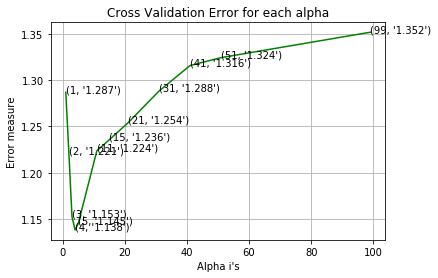

For values of best alpha =  4 The train log loss is: 0.8303084445850764
For values of best alpha =  4 The cross validation log loss is: 1.1384355885034303
For values of best alpha =  4 The test log loss is: 1.180673915834022


In [70]:
###     tfidf   ###

alpha = [1,2,3,4,5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_tfidf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


for alpha = 1
Log Loss : 1.2220951066254404
for alpha = 2
Log Loss : 1.159040215688278
for alpha = 3
Log Loss : 1.1465981154831817
for alpha = 4
Log Loss : 1.1589642302689085
for alpha = 5
Log Loss : 1.175980559407301
for alpha = 11
Log Loss : 1.2035442383742663
for alpha = 15
Log Loss : 1.2274645168310752
for alpha = 21
Log Loss : 1.264548302384869
for alpha = 31
Log Loss : 1.3266438906038591
for alpha = 41
Log Loss : 1.3736738761306209
for alpha = 51
Log Loss : 1.412957427965795
for alpha = 99
Log Loss : 1.4824448970635995


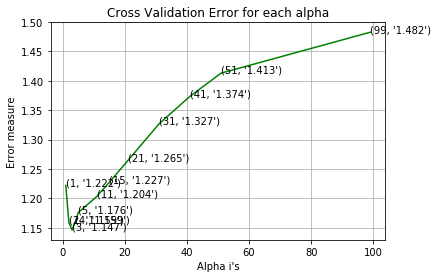

For values of best alpha =  3 The train log loss is: 0.8201705160101952
For values of best alpha =  3 The cross validation log loss is: 1.1465981154831817
For values of best alpha =  3 The test log loss is: 1.1336995347451688


In [173]:
###     tfidf_top_1000   ###

alpha = [1,2,3,4,5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_tfidf_1000, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf_1000, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf_1000)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_tfidf_1000, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf_1000, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf_1000)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidf_1000)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidf_1000)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


for alpha = 1
Log Loss : 1.2802292213641226
for alpha = 2
Log Loss : 1.2232485654261809
for alpha = 3
Log Loss : 1.1515912275616844
for alpha = 4
Log Loss : 1.1372286428081657
for alpha = 5
Log Loss : 1.145878173914682
for alpha = 11
Log Loss : 1.191604006744321
for alpha = 15
Log Loss : 1.2013271928041502
for alpha = 21
Log Loss : 1.2210566220994077
for alpha = 31
Log Loss : 1.2523828678020998
for alpha = 41
Log Loss : 1.2872909749426455
for alpha = 51
Log Loss : 1.3069033887734576
for alpha = 99
Log Loss : 1.3146856159836973


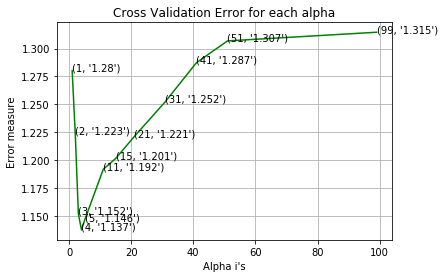

For values of best alpha =  4 The train log loss is: 0.8250446263005125
For values of best alpha =  4 The cross validation log loss is: 1.1372286428081657
For values of best alpha =  4 The test log loss is: 1.1451756522007863


In [72]:
###     unigams & bigrams   ###

alpha = [1,2,3,4,5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_bigram, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_bigram, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_bigram)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_bigram, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_bigram, train_y)

predict_y = sig_clf.predict_proba(train_x_bigram)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_bigram)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_bigram)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


Log loss : 1.3056715316187395
Number of mis-classified points : 0.4473684210526316
-------------------- Confusion matrix C --------------------


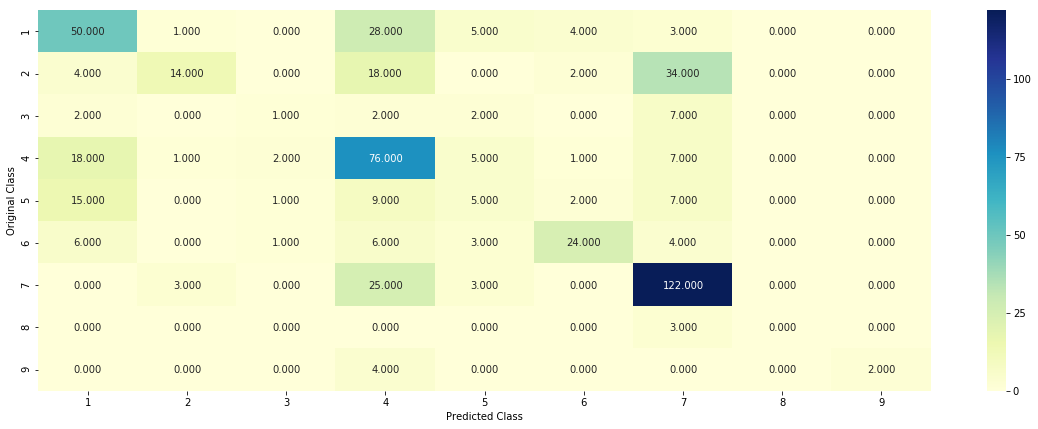

-------------------- Precision matrix (Columm Sum=1) --------------------


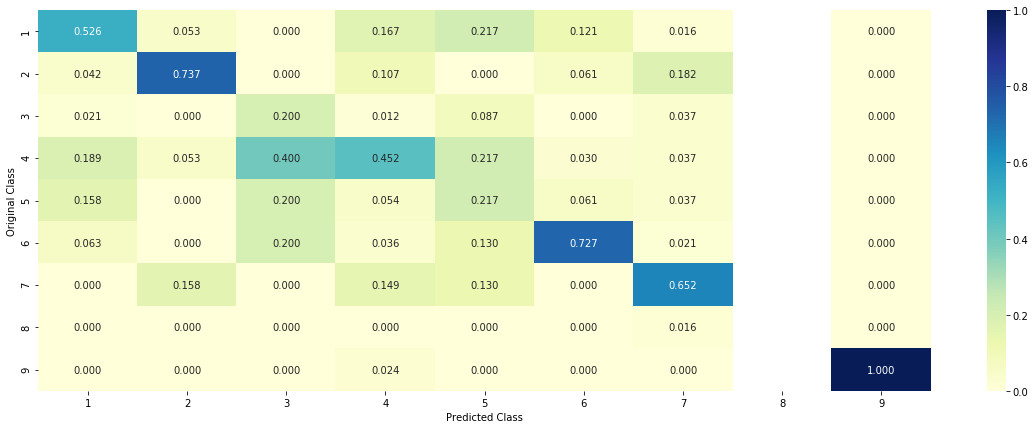

-------------------- Recall matrix (Row sum=1) --------------------


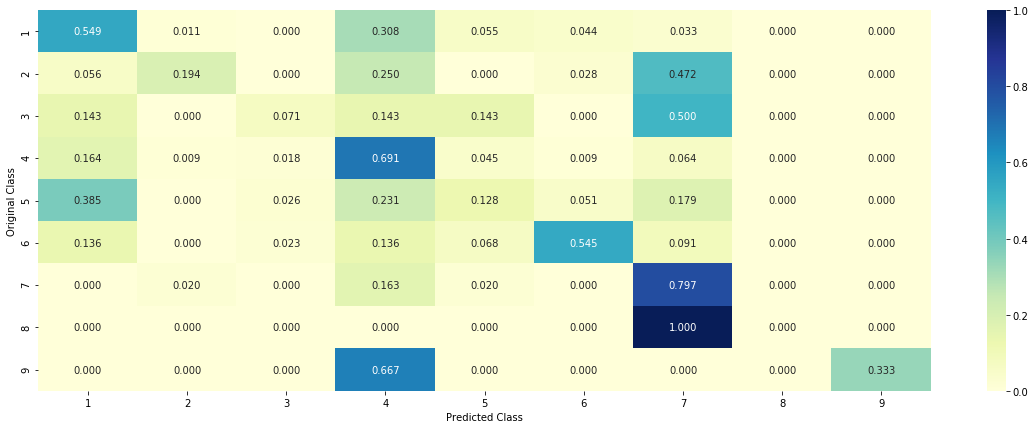

In [66]:
clf = KNeighborsClassifier(n_neighbors=5)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

Log loss : 1.0433930462105832
Number of mis-classified points : 0.3609022556390977
-------------------- Confusion matrix C --------------------


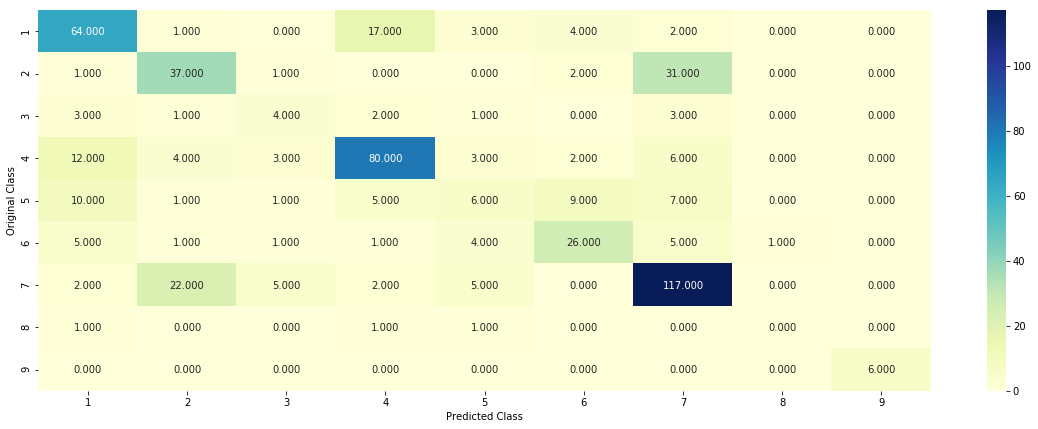

-------------------- Precision matrix (Columm Sum=1) --------------------


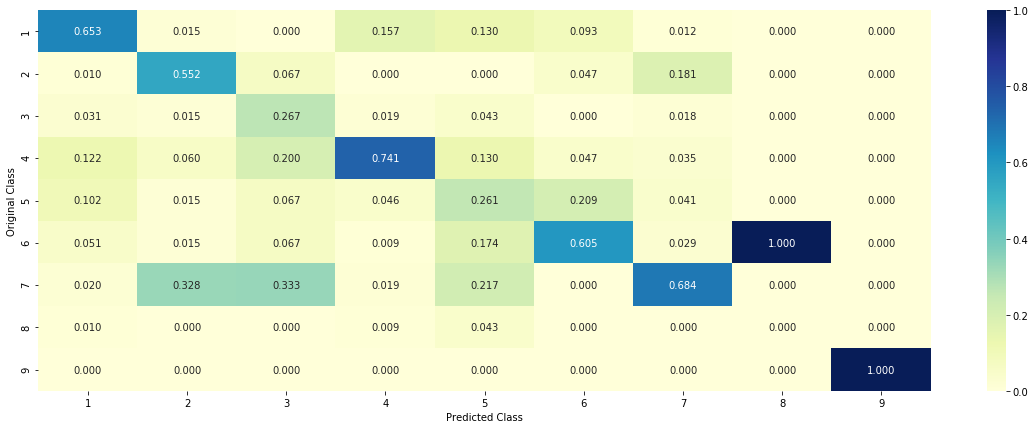

-------------------- Recall matrix (Row sum=1) --------------------


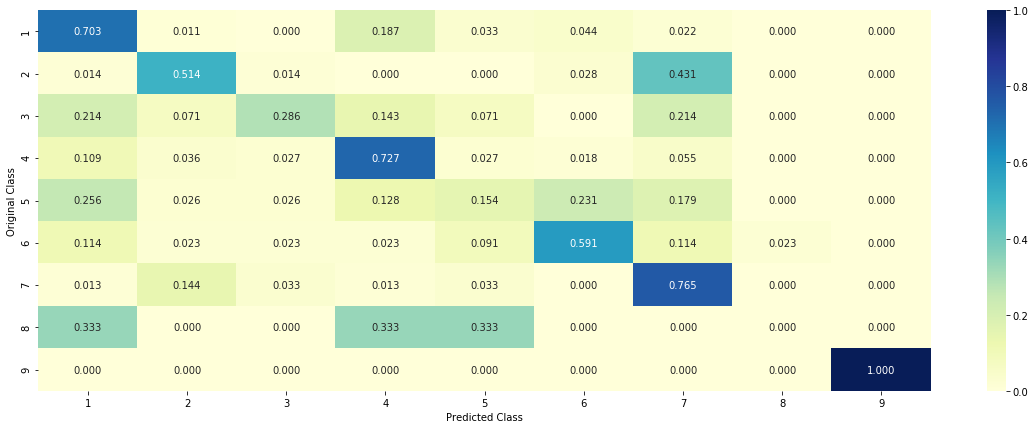

In [73]:
clf = KNeighborsClassifier(n_neighbors=5)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

Log loss : 1.1384355885034303
Number of mis-classified points : 0.41541353383458646
-------------------- Confusion matrix C --------------------


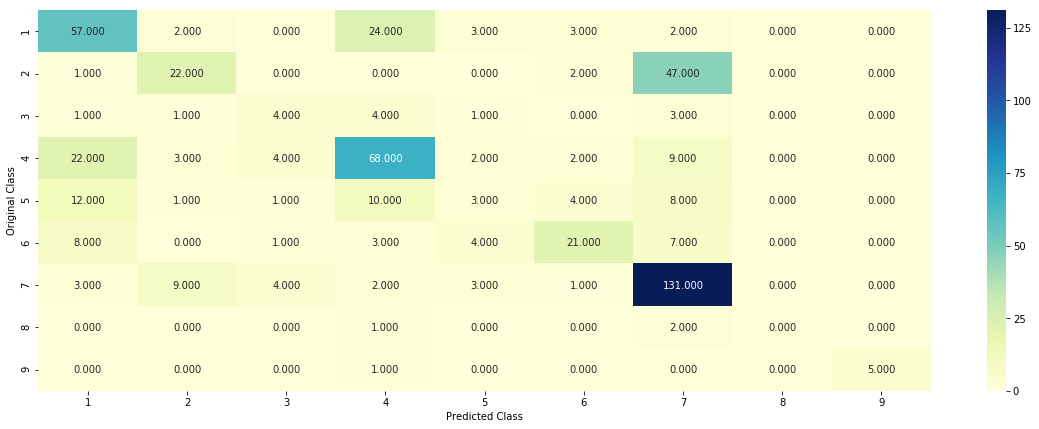

-------------------- Precision matrix (Columm Sum=1) --------------------


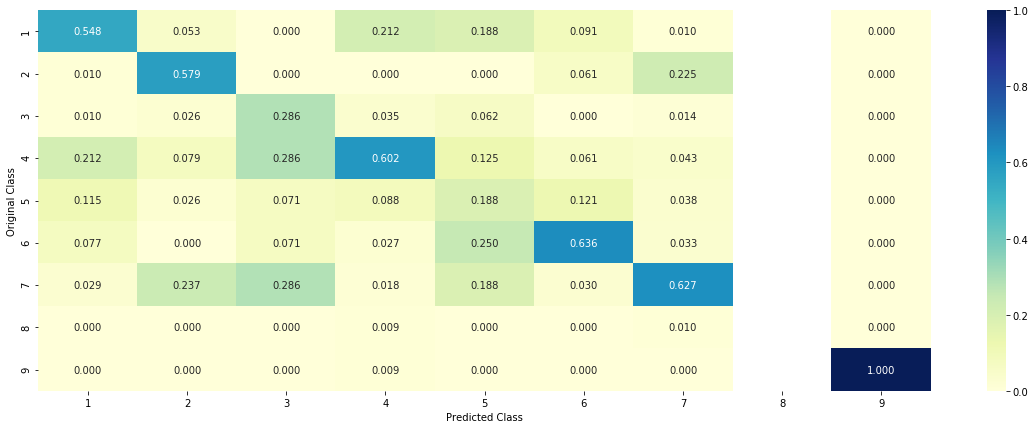

-------------------- Recall matrix (Row sum=1) --------------------


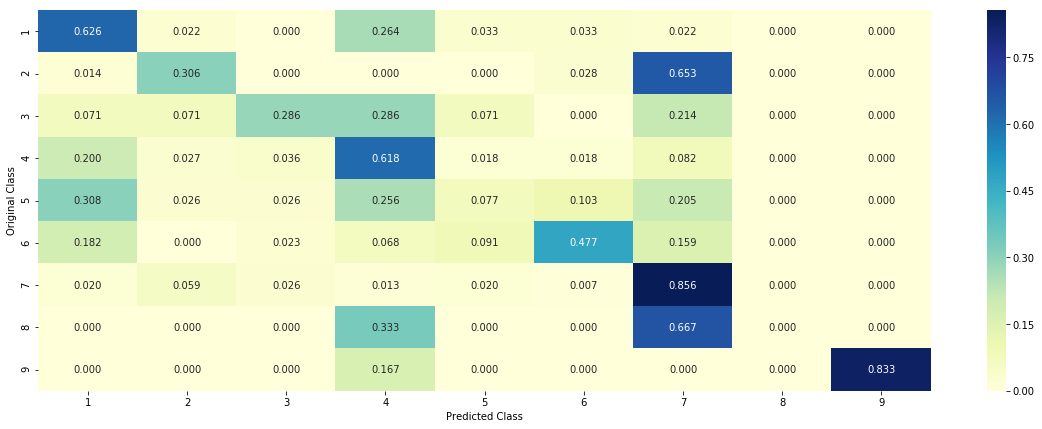

In [74]:
clf = KNeighborsClassifier(n_neighbors=4)
predict_and_plot_confusion_matrix(train_x_tfidf, train_y, cv_x_tfidf, cv_y, clf)

Log loss : 1.1372286428081657
Number of mis-classified points : 0.40789473684210525
-------------------- Confusion matrix C --------------------


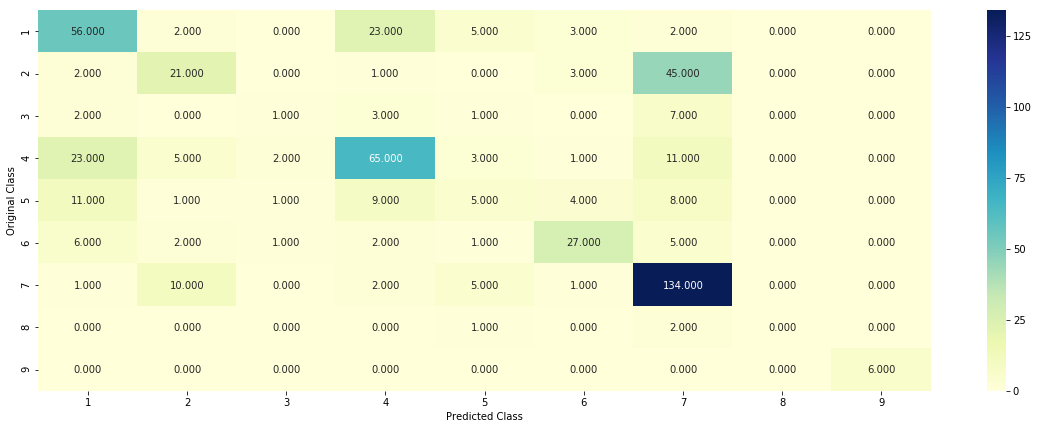

-------------------- Precision matrix (Columm Sum=1) --------------------


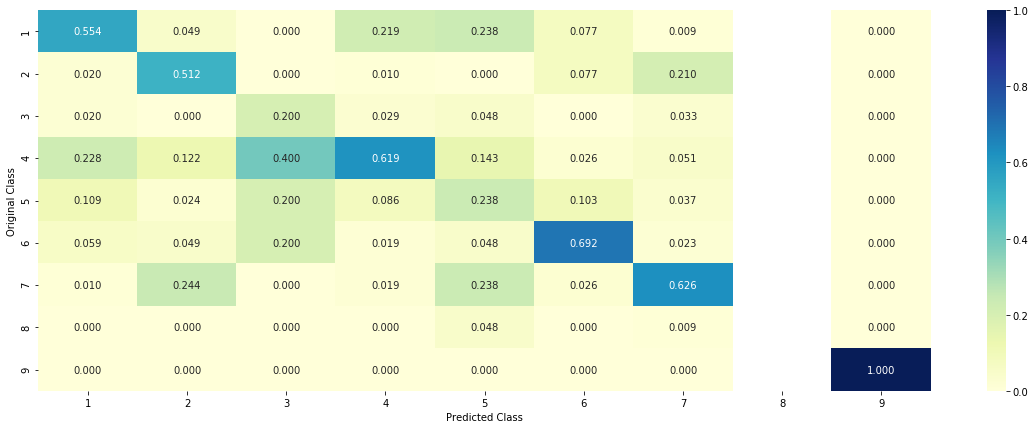

-------------------- Recall matrix (Row sum=1) --------------------


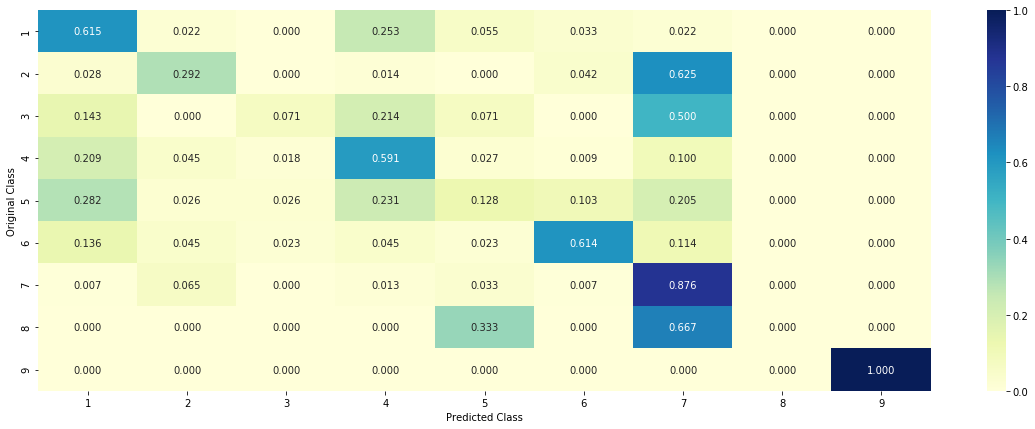

In [75]:
clf = KNeighborsClassifier(n_neighbors=4)
predict_and_plot_confusion_matrix(train_x_bigram, train_y, cv_x_bigram, cv_y, clf)

### Sample query point

In [80]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 4
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1),5)
print("The ",5," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 6
Actual Class : 6
The  5  nearest neighbours of the test points belongs to classes [7 7 7 7 7]
Fequency of nearest points : Counter({7: 5})


## Logistic Regression with class balancing

#### L2 Penalty

for C = 1e-06
Log Loss : 1.7153772324517271
for C = 1e-05
Log Loss : 1.7140256082649756
for C = 0.0001
Log Loss : 1.7006740342667386
for C = 0.001
Log Loss : 1.607947171413641
for C = 0.01
Log Loss : 1.3406353853102368
for C = 0.1
Log Loss : 1.1013913282092989
for C = 1
Log Loss : 1.038113936557323
for C = 10
Log Loss : 1.023402855022796
for C = 100
Log Loss : 1.0241445659941504


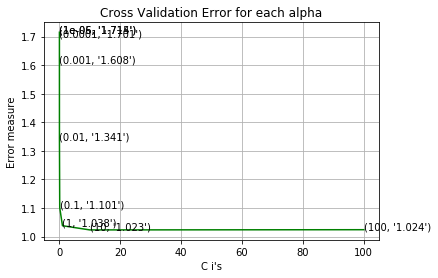

For values of best alpha =  10 The train log loss is: 0.47145133627977726
For values of best alpha =  10 The cross validation log loss is: 1.023402855022796
For values of best alpha =  10 The test log loss is: 1.1231458488730868


In [85]:
###   one hot encoding  ###

from sklearn.linear_model import LogisticRegression

alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
    clf = LogisticRegression(class_weight='balanced', C=i, penalty='l2', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("C i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = LogisticRegression(class_weight='balanced', C=alpha[best_alpha], penalty='l2', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for C = 1e-06
Log Loss : 1.830259980622008
for C = 1e-05
Log Loss : 1.830259980622008
for C = 0.0001
Log Loss : 1.830259980622008
for C = 0.001
Log Loss : 1.830259980622008
for C = 0.01
Log Loss : 1.8302599805161774
for C = 0.1
Log Loss : 1.4547706480116034
for C = 1
Log Loss : 1.1131040080695889
for C = 10
Log Loss : 1.3797902166076472
for C = 100
Log Loss : 1.6096783756109239


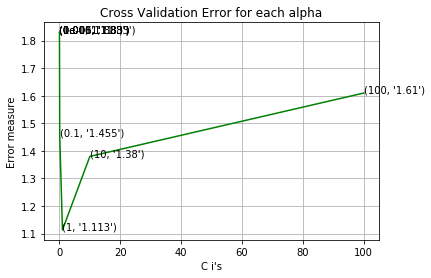

For values of best alpha =  1 The train log loss is: 0.7296060403153667
For values of best alpha =  1 The cross validation log loss is: 1.1131040080695889
For values of best alpha =  1 The test log loss is: 1.143674170050026


In [87]:
###     response encoding   ###

from sklearn.linear_model import LogisticRegression

alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
    clf = LogisticRegression(class_weight='balanced', C=i, penalty='l2', random_state=42)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("C i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = LogisticRegression(class_weight='balanced', C=alpha[best_alpha], penalty='l1', random_state=42)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for C = 1e-06
Log Loss : 1.4830002450149486
for C = 1e-05
Log Loss : 1.481922263403591
for C = 0.0001
Log Loss : 1.471913412024484
for C = 0.001
Log Loss : 1.4163951394917964
for C = 0.01
Log Loss : 1.2757351443481841
for C = 0.1
Log Loss : 1.173231804347948
for C = 1
Log Loss : 1.0357315443592965
for C = 10
Log Loss : 0.9731234098656992
for C = 100
Log Loss : 0.9657348569225096


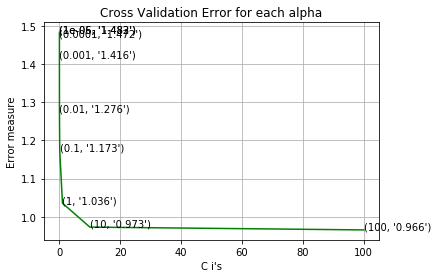

For values of best alpha =  100 The train log loss is: 0.35982474035742557
For values of best alpha =  100 The cross validation log loss is: 0.9657348569225096
For values of best alpha =  100 The test log loss is: 1.0155875706088218


In [89]:
###     tf-idf   ###

from sklearn.linear_model import LogisticRegression

alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
    clf = LogisticRegression(class_weight='balanced', C=i, penalty='l2', random_state=42)
    clf.fit(train_x_tfidf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("C i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = LogisticRegression(class_weight='balanced', C=alpha[best_alpha], penalty='l2', random_state=42)
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for C = 1e-06
Log Loss : 1.6940804726640721
for C = 1e-05
Log Loss : 1.6929128244463874
for C = 0.0001
Log Loss : 1.683230008683067
for C = 0.001
Log Loss : 1.5939231370665192
for C = 0.01
Log Loss : 1.3678015448793108
for C = 0.1
Log Loss : 1.2651616943288289
for C = 1
Log Loss : 1.1739413187448295
for C = 10
Log Loss : 1.1466354673715815
for C = 100
Log Loss : 1.1690532527544175


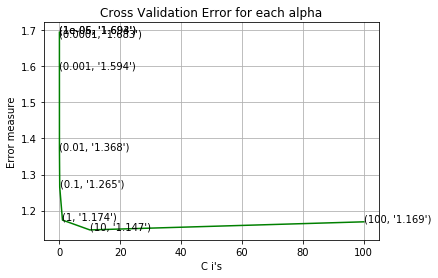

For values of best alpha =  10 The train log loss is: 0.5155821703007474
For values of best alpha =  10 The cross validation log loss is: 1.1466354673715815
For values of best alpha =  10 The test log loss is: 1.0840763596572283


In [175]:
###     tf-idf_1000   ###

from sklearn.linear_model import LogisticRegression

alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
    clf = LogisticRegression(class_weight='balanced', C=i, penalty='l2', random_state=42)
    clf.fit(train_x_tfidf_1000, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf_1000, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf_1000)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("C i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = LogisticRegression(class_weight='balanced', C=alpha[best_alpha], penalty='l2', random_state=42)
clf.fit(train_x_tfidf_1000, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf_1000, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf_1000)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidf_1000)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidf_1000)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for C = 1e-06
Log Loss : 1.6239714726201868
for C = 1e-05
Log Loss : 1.622943377406877
for C = 0.0001
Log Loss : 1.6130490950443457
for C = 0.001
Log Loss : 1.5243007356749558
for C = 0.01
Log Loss : 1.2792909618955381
for C = 0.1
Log Loss : 1.1429029625824008
for C = 1
Log Loss : 1.0243880345210254
for C = 10
Log Loss : 0.9884481521282874
for C = 100
Log Loss : 0.9880119373193642


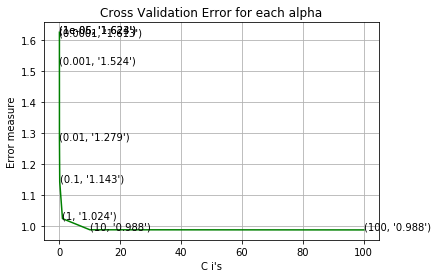

For values of best alpha =  100 The train log loss is: 0.35683224674044395
For values of best alpha =  100 The cross validation log loss is: 0.9880119373193642
For values of best alpha =  100 The test log loss is: 0.9944799243046681


In [31]:
### unibrams and bigrams ####

from sklearn.linear_model import LogisticRegression

alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
    clf = LogisticRegression(class_weight='balanced', C=i, penalty='l2', random_state=42)
    clf.fit(train_x_bigram, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_bigram, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_bigram)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("C i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = LogisticRegression(class_weight='balanced', C=alpha[best_alpha], penalty='l2', random_state=42)
clf.fit(train_x_bigram, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_bigram, train_y)

predict_y = sig_clf.predict_proba(train_x_bigram)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_bigram)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_bigram)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

#### L1 Penalty

for C = 1e-06
Log Loss : 1.8302599806220075
for C = 1e-05
Log Loss : 1.8302599806220075
for C = 0.0001
Log Loss : 1.8302599806220075
for C = 0.001
Log Loss : 1.8302599806220075
for C = 0.01
Log Loss : 1.8302599805161914
for C = 0.1
Log Loss : 1.5746358725038543
for C = 1
Log Loss : 1.2085608595467434
for C = 10
Log Loss : 1.131870687165108
for C = 100
Log Loss : 1.1453500860744343


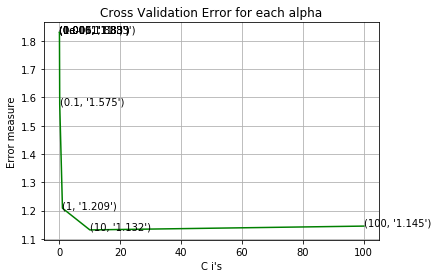

For values of best alpha =  10 The train log loss is: 0.5693889601572583
For values of best alpha =  10 The cross validation log loss is: 1.131870687165108
For values of best alpha =  10 The test log loss is: 1.1193500551773166


In [33]:
### one hot encoding ####

from sklearn.linear_model import LogisticRegression

alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
    clf = LogisticRegression(class_weight='balanced', C=i, penalty='l1', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("C i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = LogisticRegression(class_weight='balanced', C=alpha[best_alpha], penalty='l1', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for C = 1e-06
Log Loss : 1.8302599806220075
for C = 1e-05
Log Loss : 1.8302599806220075
for C = 0.0001
Log Loss : 1.8302599806220075
for C = 0.001
Log Loss : 1.8302599806220075
for C = 0.01
Log Loss : 1.8302599805161737
for C = 0.1
Log Loss : 1.4495866004528752
for C = 1
Log Loss : 1.100490562982241
for C = 10
Log Loss : 1.276541578500496
for C = 100
Log Loss : 1.4343538932762419


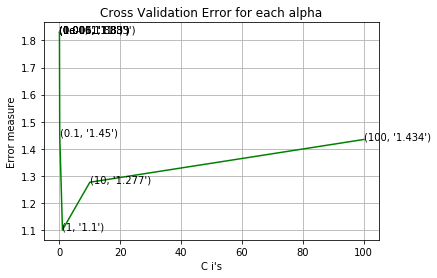

For values of best alpha =  1 The train log loss is: 0.7269055097397219
For values of best alpha =  1 The cross validation log loss is: 1.100490562982241
For values of best alpha =  1 The test log loss is: 1.0681627674090317


In [35]:
### response coding ####

from sklearn.linear_model import LogisticRegression

alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
    clf = LogisticRegression(class_weight='balanced', C=i, penalty='l1', random_state=42)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("C i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = LogisticRegression(class_weight='balanced', C=alpha[best_alpha], penalty='l1', random_state=42)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for C = 1e-06
Log Loss : 1.4736688000476297
for C = 1e-05
Log Loss : 1.472554913150961
for C = 0.0001
Log Loss : 1.461096770957856
for C = 0.001
Log Loss : 1.3769722018098354
for C = 0.01
Log Loss : 1.2273075114007104
for C = 0.1
Log Loss : 1.1472943390549615
for C = 1
Log Loss : 1.0202365781149267
for C = 10
Log Loss : 0.9746766429141774
for C = 100
Log Loss : 0.9712052728177807


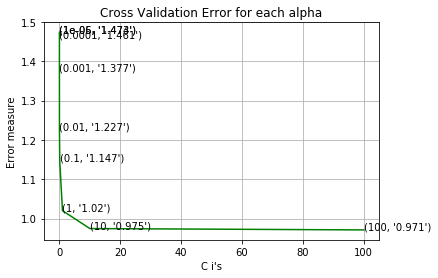

For values of best alpha =  100 The train log loss is: 0.3538046387974245
For values of best alpha =  100 The cross validation log loss is: 0.9712052728177807
For values of best alpha =  100 The test log loss is: 0.9740855091628409


In [36]:
### tfidf ####

from sklearn.linear_model import LogisticRegression

alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
    clf = LogisticRegression(class_weight='balanced', C=i, penalty='l2', random_state=42)
    clf.fit(train_x_tfidf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("C i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = LogisticRegression(class_weight='balanced', C=alpha[best_alpha], penalty='l2', random_state=42)
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for C = 1e-06
Log Loss : 1.8302599806220075
for C = 1e-05
Log Loss : 1.8302599806220075
for C = 0.0001
Log Loss : 1.8302599806220075
for C = 0.001
Log Loss : 1.8302599806220075
for C = 0.01
Log Loss : 1.8302599805161914
for C = 0.1
Log Loss : 1.5742280708275005
for C = 1
Log Loss : 1.188694352806603
for C = 10
Log Loss : 1.1455273397603278
for C = 100
Log Loss : 1.186401815853941


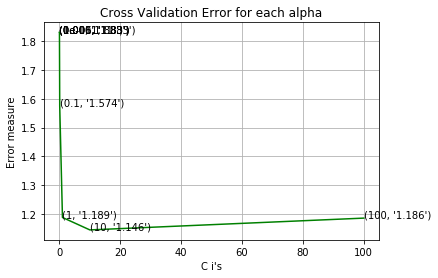

For values of best alpha =  10 The train log loss is: 0.5764272529234226
For values of best alpha =  10 The cross validation log loss is: 1.1455273397603278
For values of best alpha =  10 The test log loss is: 1.1437026649162079


In [38]:
### unibrams and bigrams ####

from sklearn.linear_model import LogisticRegression

alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
    clf = LogisticRegression(class_weight='balanced', C=i, penalty='l1', random_state=42)
    clf.fit(train_x_bigram, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_bigram, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_bigram)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("C i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = LogisticRegression(class_weight='balanced', C=alpha[best_alpha], penalty='l1', random_state=42)
clf.fit(train_x_bigram, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_bigram, train_y)

predict_y = sig_clf.predict_proba(train_x_bigram)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_bigram)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_bigram)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

#### Observation

Logistic regression works best with l2 regularization on unigrams and bigrams
- Test log-loss : 0.99
- Cv log-loss : 0.98 

In [41]:
clf = LogisticRegression(class_weight='balanced',C=100, penalty='l2', random_state=42)
clf.fit(train_x_bigram,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_bigram[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_bigram[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names_bigram(indices[0], test_df['Text'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 6
Predicted Class Probabilities: [[0.1735 0.0763 0.0145 0.1652 0.0734 0.3024 0.1804 0.0058 0.0085]]
Actual Class : 4
--------------------------------------------------
91 Text feature [resistance] present in test data point [True]
92 Text feature [nras] present in test data point [True]
99 Text feature [identified] present in test data point [True]
103 Text feature [mll2] present in test data point [True]
129 Text feature [erbb2] present in test data point [True]
141 Text feature [site] present in test data point [True]
154 Text feature [associated] present in test data point [True]
162 Text feature [values] present in test data point [True]
167 Text feature [pathway] present in test data point [True]
168 Text feature [snps] present in test data point [True]
170 Text feature [pik3ca] present in test data point [True]
173 Text feature [significant] present in test data point [True]
180 Text feature [missense] present in test data point [True]
186 Text feature [differen

Log loss : 0.9880119373193642
Number of mis-classified points : 0.3458646616541353
-------------------- Confusion matrix C --------------------


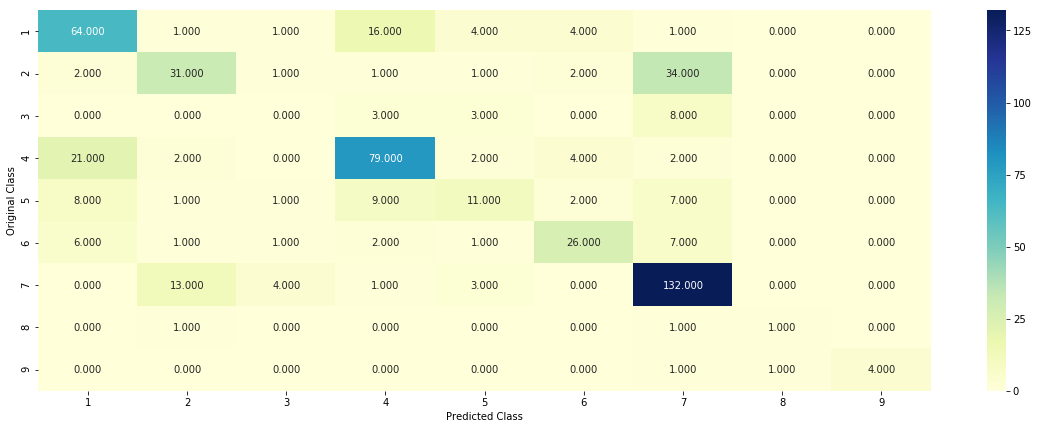

-------------------- Precision matrix (Columm Sum=1) --------------------


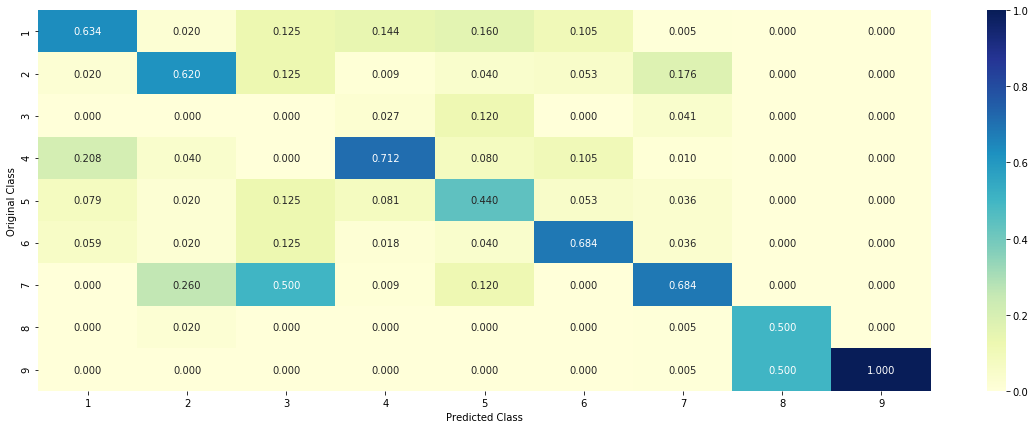

-------------------- Recall matrix (Row sum=1) --------------------


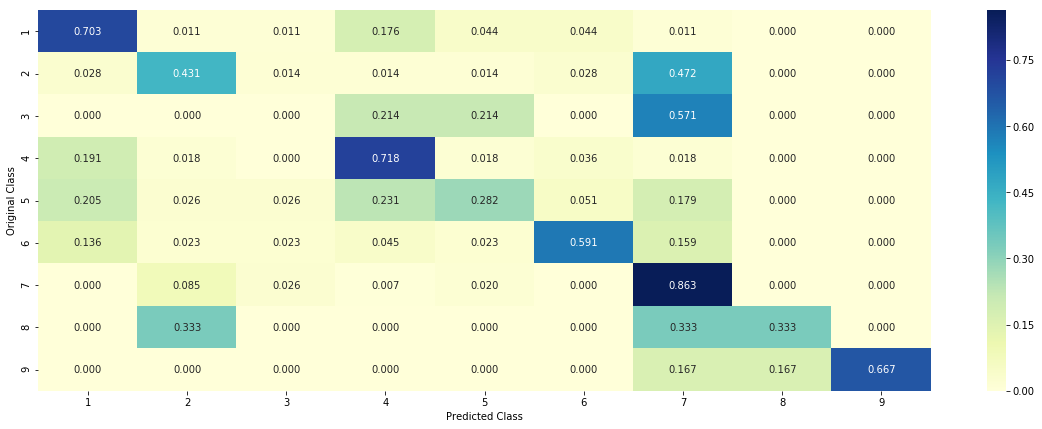

In [43]:
clf = LogisticRegression(class_weight='balanced',C=100, penalty='l2', random_state=42)
predict_and_plot_confusion_matrix(train_x_bigram, train_y, cv_x_bigram ,cv_y, clf)

## Logistic Regression without class balancing


for C = 1e-06
Log Loss : 1.5504314855302745
for C = 1e-05
Log Loss : 1.5493167991609822
for C = 0.0001
Log Loss : 1.5383637740084042
for C = 0.001
Log Loss : 1.4491267853278533
for C = 0.01
Log Loss : 1.2649663166589935
for C = 0.1
Log Loss : 1.1431235859667583
for C = 1
Log Loss : 1.01929239596495
for C = 10
Log Loss : 0.9894086898798072
for C = 100
Log Loss : 0.989238336524359


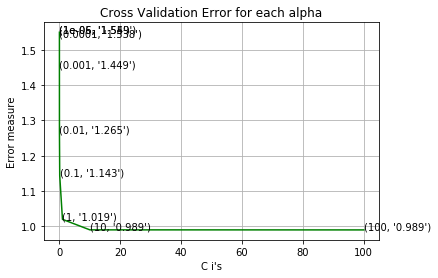

For values of best alpha =  100 The train log loss is: 0.35683224674044395
For values of best alpha =  100 The cross validation log loss is: 0.9880119373193642
For values of best alpha =  100 The test log loss is: 0.9944799243046681


In [44]:
### unibrams and bigrams ####

from sklearn.linear_model import LogisticRegression

alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
    clf = LogisticRegression(C=i, penalty='l2', random_state=42)
    clf.fit(train_x_bigram, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_bigram, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_bigram)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("C i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = LogisticRegression(class_weight='balanced', C=alpha[best_alpha], penalty='l2', random_state=42)
clf.fit(train_x_bigram, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_bigram, train_y)

predict_y = sig_clf.predict_proba(train_x_bigram)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_bigram)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_bigram)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for C = 1e-06
Log Loss : 1.6706546989505937
for C = 1e-05
Log Loss : 1.669195529855924
for C = 0.0001
Log Loss : 1.6544860965548953
for C = 0.001
Log Loss : 1.5114508247920895
for C = 0.01
Log Loss : 1.3011196268725767
for C = 0.1
Log Loss : 1.0538915608988204
for C = 1
Log Loss : 1.0434528545730852
for C = 10
Log Loss : 1.0542505338654002
for C = 100
Log Loss : 1.0599893081998286


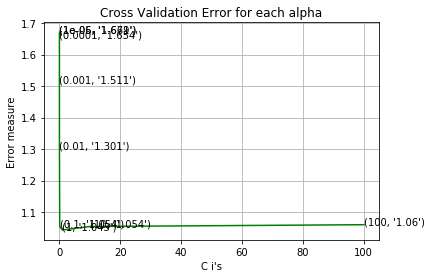

For values of best alpha =  1 The train log loss is: 0.5185082523065887
For values of best alpha =  1 The cross validation log loss is: 1.0434528545730852
For values of best alpha =  1 The test log loss is: 1.0101919303227307


In [25]:
###  One hot encoded  ###
from sklearn.linear_model import LogisticRegression

alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
    clf = LogisticRegression(C=i, penalty='l2', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("C i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = LogisticRegression(C=alpha[best_alpha], penalty='l2', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for C = 1e-06
Log Loss : 1.4606783509614898
for C = 1e-05
Log Loss : 1.4602494702967868
for C = 0.0001
Log Loss : 1.454747674275368
for C = 0.001
Log Loss : 1.4166676474666486
for C = 0.01
Log Loss : 1.2786187056315188
for C = 0.1
Log Loss : 1.2524212979589218
for C = 1
Log Loss : 1.1709179692857195
for C = 10
Log Loss : 1.085551470710214
for C = 100
Log Loss : 1.0672901797707652


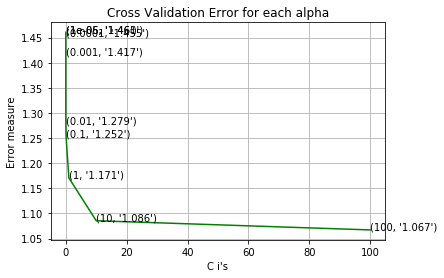

For values of best alpha =  100 The train log loss is: 0.5314154670012974
For values of best alpha =  100 The cross validation log loss is: 1.0672901797707652
For values of best alpha =  100 The test log loss is: 1.028014311477435


In [26]:
### Response Coding   ###
from sklearn.linear_model import LogisticRegression

alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
    clf = LogisticRegression(C=i, penalty='l2', random_state=42)
    clf.fit(train_x_bigram, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("C i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = LogisticRegression(C=alpha[best_alpha], penalty='l2', random_state=42)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for C = 1e-06
Log Loss : 1.4049824317570194
for C = 1e-05
Log Loss : 1.4041518099872292
for C = 0.0001
Log Loss : 1.3961898464228824
for C = 0.001
Log Loss : 1.3427264063624205
for C = 0.01
Log Loss : 1.231481569707793
for C = 0.1
Log Loss : 1.116568479869471
for C = 1
Log Loss : 0.9912717092611146
for C = 10
Log Loss : 0.9556996468092082
for C = 100
Log Loss : 0.9573927238039176


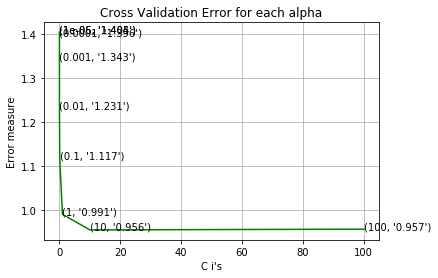

For values of best alpha =  10 The train log loss is: 0.412310090310137
For values of best alpha =  10 The cross validation log loss is: 0.9556996468092082
For values of best alpha =  10 The test log loss is: 0.9276664553966533


In [27]:
### tf-idf ###
from sklearn.linear_model import LogisticRegression

alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
    clf = LogisticRegression(C=i, penalty='l2', random_state=42)
    clf.fit(train_x_tfidf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("C i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = LogisticRegression(C=alpha[best_alpha], penalty='l2', random_state=42)
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for C = 1e-06
Log Loss : 1.830259980622008
for C = 1e-05
Log Loss : 1.830259980622008
for C = 0.0001
Log Loss : 1.830259980622008
for C = 0.001
Log Loss : 1.830259980622008
for C = 0.01
Log Loss : 1.8302599804752646
for C = 0.1
Log Loss : 1.5665533321421452
for C = 1
Log Loss : 1.231157194665574
for C = 10
Log Loss : 1.311252925610039
for C = 100
Log Loss : 1.3788641192761186


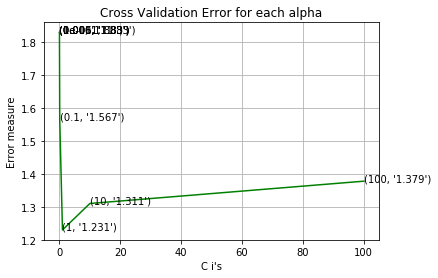

For values of best alpha =  1 The train log loss is: 1.0758039462840623
For values of best alpha =  1 The cross validation log loss is: 1.231157194665574
For values of best alpha =  1 The test log loss is: 1.153275729626676


In [183]:
### tfidf_1000 ####

from sklearn.linear_model import LogisticRegression

alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
    clf = LogisticRegression(C=i, penalty='l1', random_state=42)
    clf.fit(train_x_tfidf_1000, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf_1000, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf_1000)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("C i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = LogisticRegression(C=alpha[best_alpha], penalty='l1', random_state=42)
clf.fit(train_x_tfidf_1000, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf_1000)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidf_1000)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidf_1000)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for C = 1e-06
Log Loss : 1.5307291459783066
for C = 1e-05
Log Loss : 1.5297136860831133
for C = 0.0001
Log Loss : 1.5193169141262515
for C = 0.001
Log Loss : 1.4366160996120325
for C = 0.01
Log Loss : 1.258910259019204
for C = 0.1
Log Loss : 1.118566093302461
for C = 1
Log Loss : 0.9955641929677045
for C = 10
Log Loss : 0.9639741332141862
for C = 100
Log Loss : 0.9677781944800259


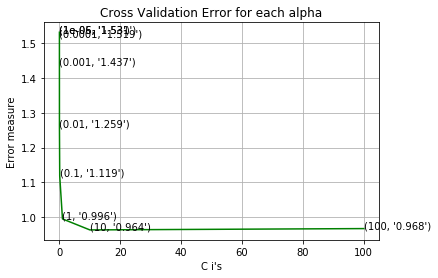

For values of best alpha =  10 The train log loss is: 0.42377407053147603
For values of best alpha =  10 The cross validation log loss is: 0.9639741332141862
For values of best alpha =  10 The test log loss is: 0.9395681703675


In [28]:
### bi-grams ###
from sklearn.linear_model import LogisticRegression

alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
    clf = LogisticRegression(C=i, penalty='l2', random_state=42)
    clf.fit(train_x_bigram, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_bigram, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_bigram)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("C i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = LogisticRegression(C=alpha[best_alpha], penalty='l2', random_state=42)
clf.fit(train_x_bigram, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_bigram, train_y)

predict_y = sig_clf.predict_proba(train_x_bigram)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_bigram)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_bigram)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

## Random Forest Classifier

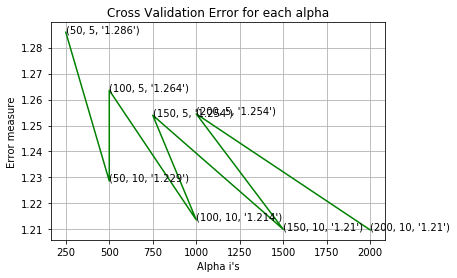

For values of best estimator =  200 The train log loss is: 0.7036396996615581
For values of best estimator =  200 The cross validation log loss is: 1.2098055511747225
For values of best estimator =  200 The test log loss is: 1.1112178531758659


In [31]:
### One hot encoding ###


alpha = [50,100,150,200]
max_depth = [5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        #print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        #print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/2)],max_depth[int(i%2)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

#### Plot confusion matrix using best hyper parameters

Log loss : 1.2098055511747225
Number of mis-classified points : 0.40037593984962405
-------------------- Confusion matrix C --------------------


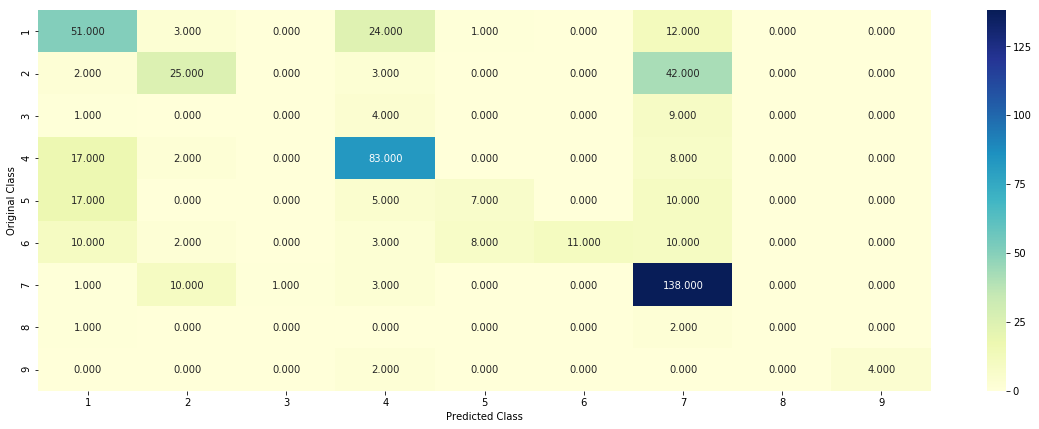

-------------------- Precision matrix (Columm Sum=1) --------------------


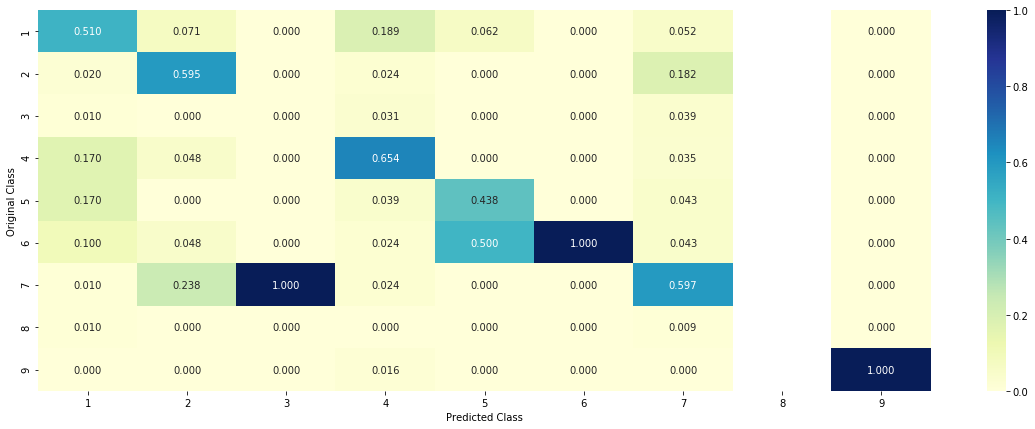

-------------------- Recall matrix (Row sum=1) --------------------


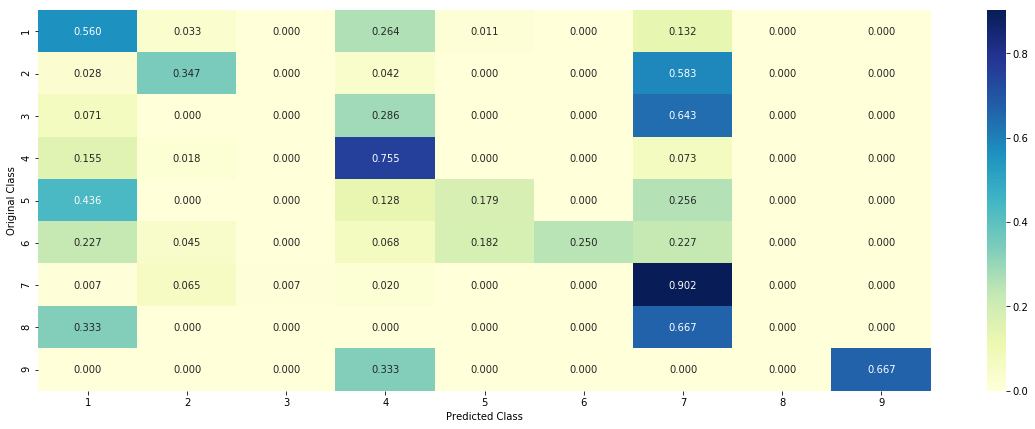

In [44]:
clf = RandomForestClassifier(n_estimators=200 ,criterion='gini', max_depth=10, random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y,clf)

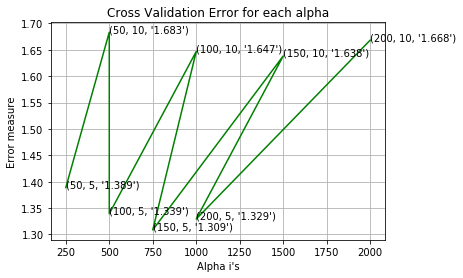

For values of best estimator =  150 The train log loss is: 0.051741279071507065
For values of best estimator =  150 The cross validation log loss is: 1.3086805970918045
For values of best estimator =  150 The test log loss is: 1.280396382684137


In [37]:
### response coding ###


alpha = [50,100,150,200]
max_depth = [5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        #print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        #print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/2)],max_depth[int(i%2)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.638247043313935
Number of mis-classified points : 0.6203007518796992
-------------------- Confusion matrix C --------------------


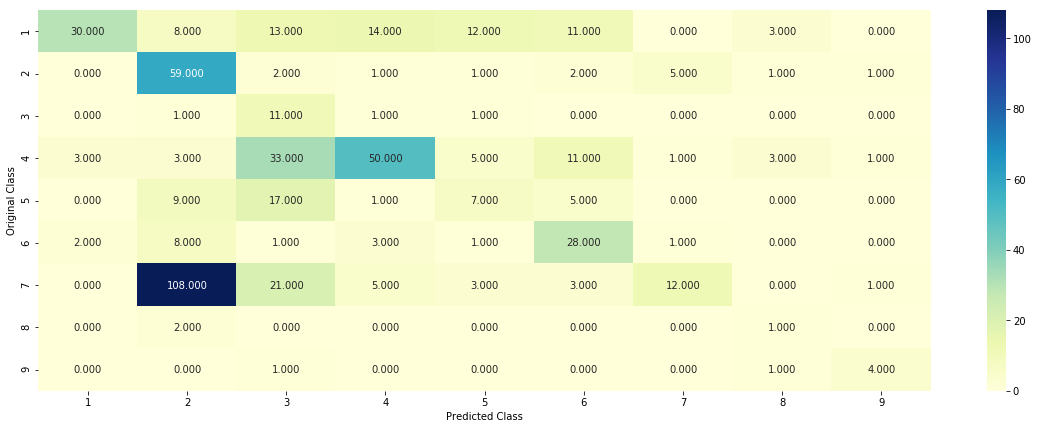

-------------------- Precision matrix (Columm Sum=1) --------------------


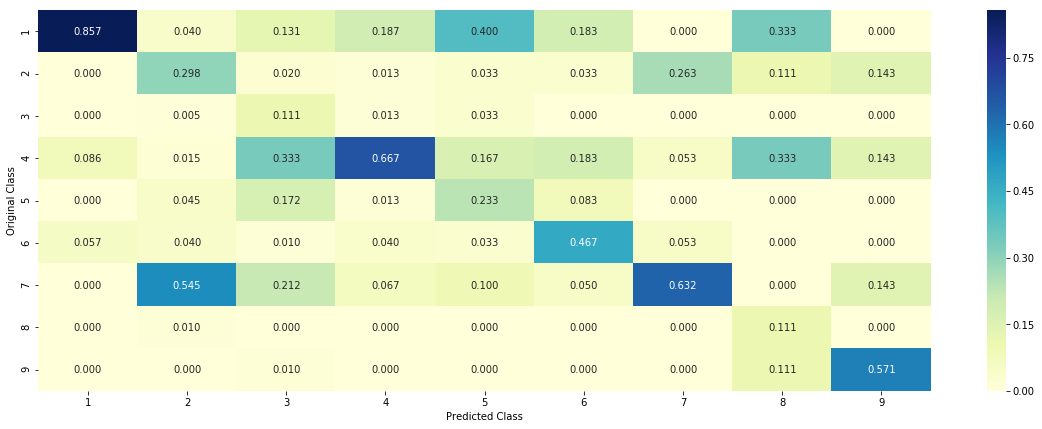

-------------------- Recall matrix (Row sum=1) --------------------


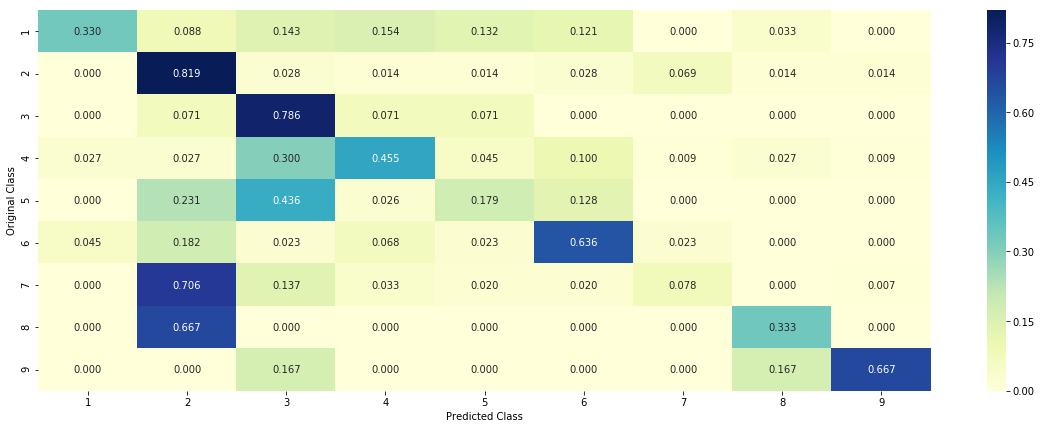

In [46]:
clf = RandomForestClassifier(n_estimators=150 ,criterion='gini', max_depth=10, random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y,cv_x_responseCoding,cv_y,clf)

In [42]:
clf = RandomForestClassifier(n_estimators=200, criterion='gini', max_depth=10, random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)


test_point_index = 1
no_feature = 27
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 1
Predicted Class Probabilities: [[0.9538 0.0044 0.0028 0.0087 0.0024 0.0148 0.0048 0.0051 0.0032]]
Actual Class : 4
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Text is important feature
Text is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Gene is important feature
Text is important feature
Gene is important feature
Text is important feature
Variation is important feature
Text is important feature
Gene is important feature
Text is important feature
Gene is important feature
Gene is important feature
Variation is important feature
Gene is important feature


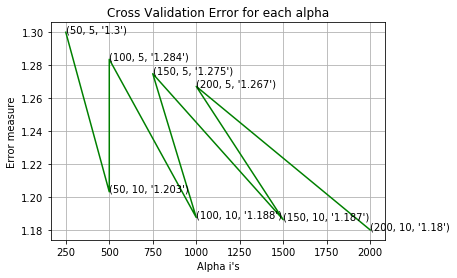

For values of best estimator =  200 The train log loss is: 0.8518513049399126
For values of best estimator =  200 The cross validation log loss is: 1.1802881599918493
For values of best estimator =  200 The test log loss is: 1.0973690035828612


In [38]:
### tf-idf ###


alpha = [50,100,150,200]
max_depth = [5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        #print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_tfidf, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_tfidf, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        #print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/2)],max_depth[int(i%2)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.1802881599918493
Number of mis-classified points : 0.38345864661654133
-------------------- Confusion matrix C --------------------


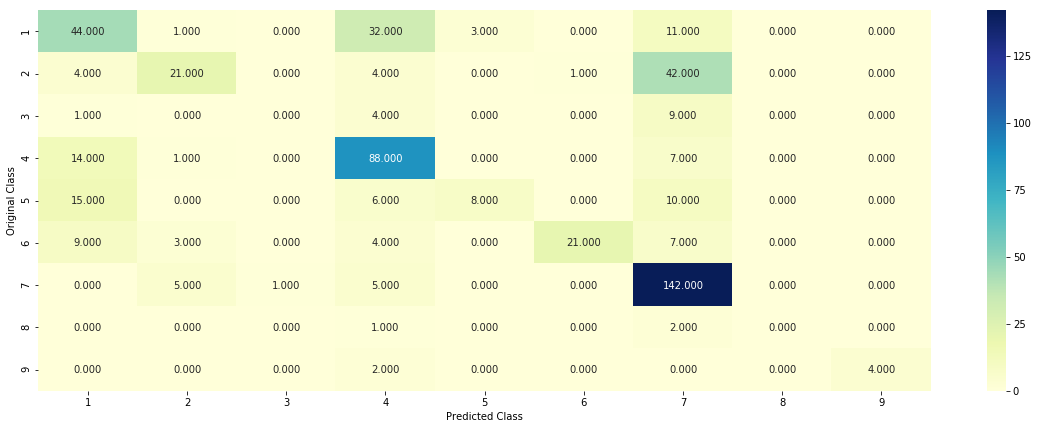

-------------------- Precision matrix (Columm Sum=1) --------------------


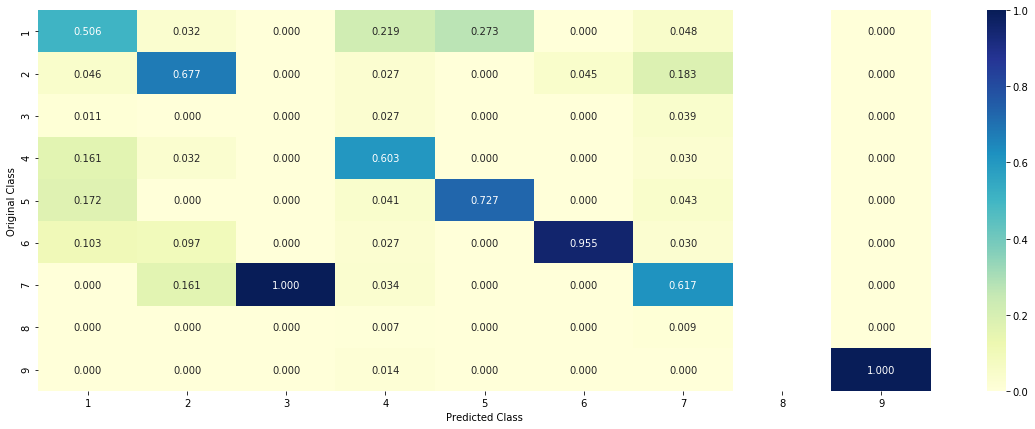

-------------------- Recall matrix (Row sum=1) --------------------


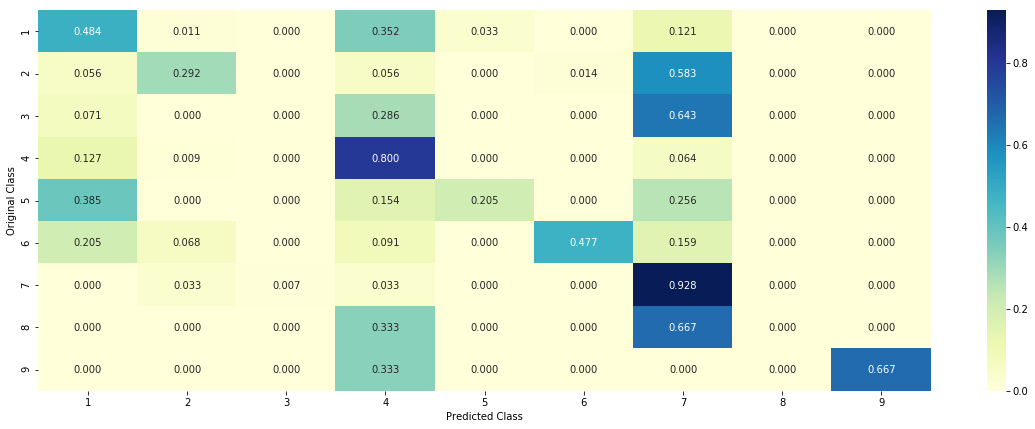

In [47]:
clf = RandomForestClassifier(n_estimators=200 ,criterion='gini', max_depth=10, random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_tfidf, train_y,cv_x_tfidf,cv_y,clf)

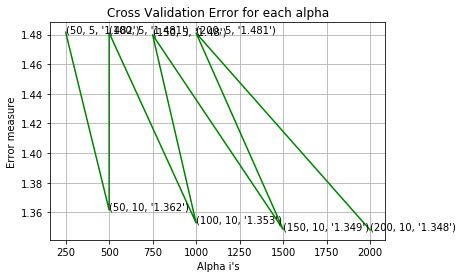

For values of best estimator =  200 The train log loss is: 0.8285964856986997
For values of best estimator =  200 The cross validation log loss is: 1.3481309530465933
For values of best estimator =  200 The test log loss is: 1.3626243219118015


In [177]:
### tf-idf_1000 ###


alpha = [50,100,150,200]
max_depth = [5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        #print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_tfidf_1000, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_tfidf_1000, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf_1000)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        #print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/2)],max_depth[int(i%2)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_tfidf_1000, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf_1000, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf_1000)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidf_1000)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidf_1000)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.3481309530465933
Number of mis-classified points : 0.462406015037594
-------------------- Confusion matrix C --------------------


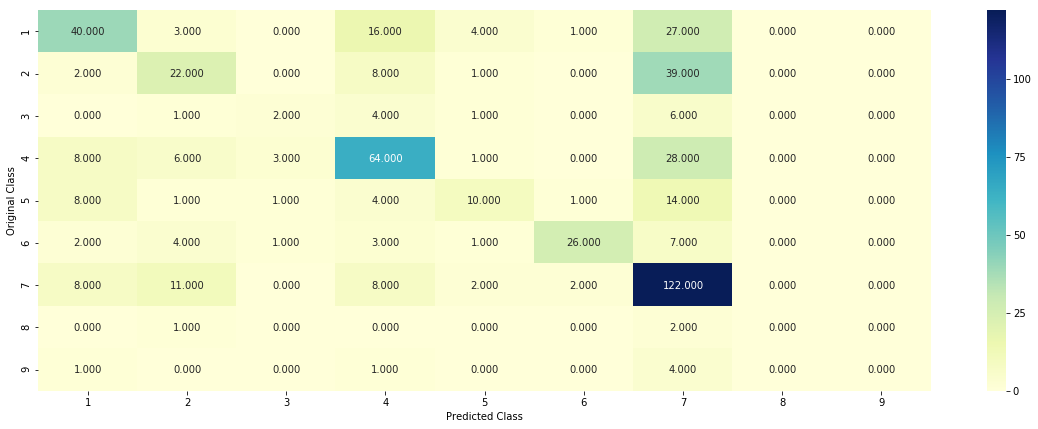

-------------------- Precision matrix (Columm Sum=1) --------------------


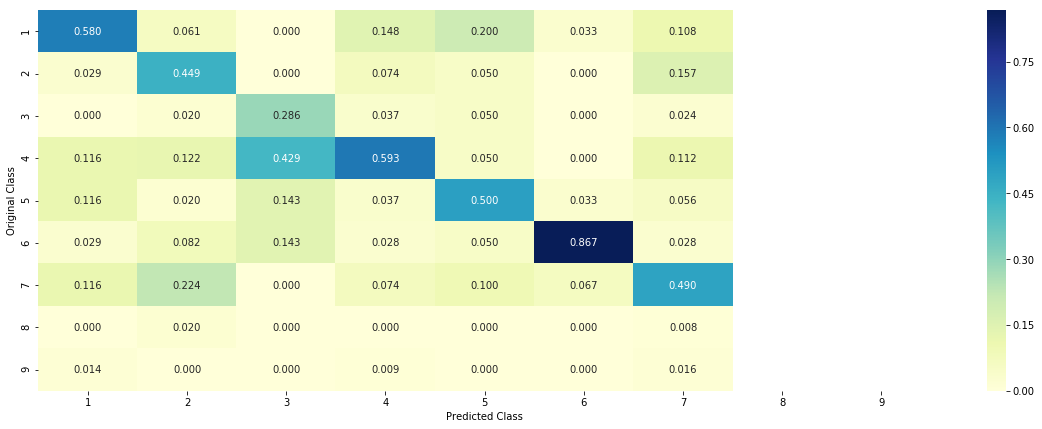

-------------------- Recall matrix (Row sum=1) --------------------


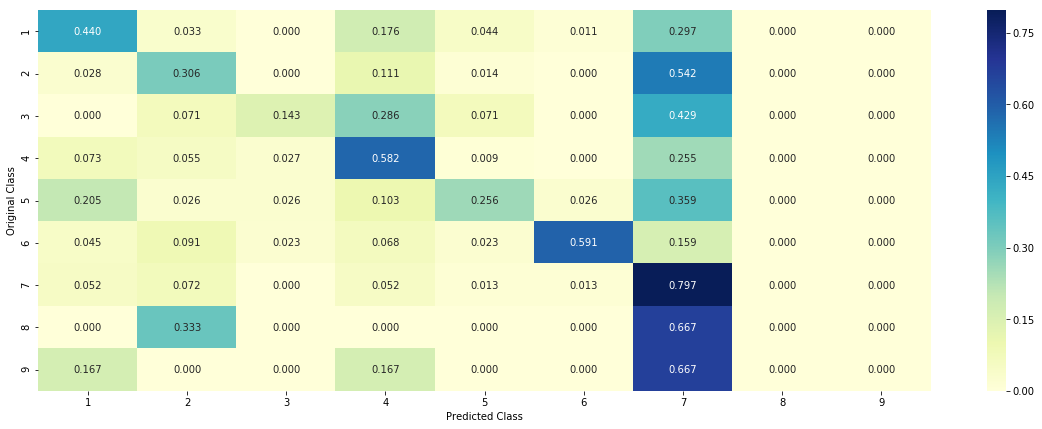

In [178]:
clf = RandomForestClassifier(n_estimators=200 ,criterion='gini', max_depth=10, random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_tfidf, train_y,cv_x_tfidf,cv_y,clf)

In [46]:
clf = RandomForestClassifier(n_estimators=200, criterion='gini', max_depth=10, random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


test_point_index = 5
no_feature = 27
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names_tfidf(indices[:no_feature], test_df['Text'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.0973 0.0213 0.0478 0.4357 0.067  0.2654 0.0527 0.005  0.0078]]
Actual Class : 6
--------------------------------------------------
Out of the top  27  features  0 are present in query point


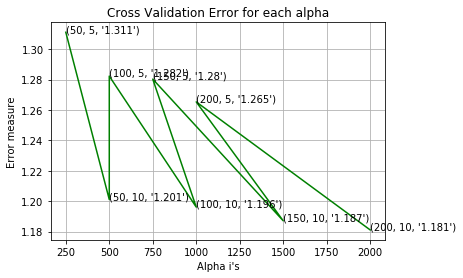

For values of best estimator =  200 The train log loss is: 0.8408554616330862
For values of best estimator =  200 The cross validation log loss is: 1.1810618985425585
For values of best estimator =  200 The test log loss is: 1.0949800313952898


In [39]:
### bigram ###


alpha = [50,100,150,200]
max_depth = [5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        #print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_bigram, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_bigram, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_bigram)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        #print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/2)],max_depth[int(i%2)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_bigram, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_bigram, train_y)

predict_y = sig_clf.predict_proba(train_x_bigram)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_bigram)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_bigram)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.1810618985425587
Number of mis-classified points : 0.38721804511278196
-------------------- Confusion matrix C --------------------


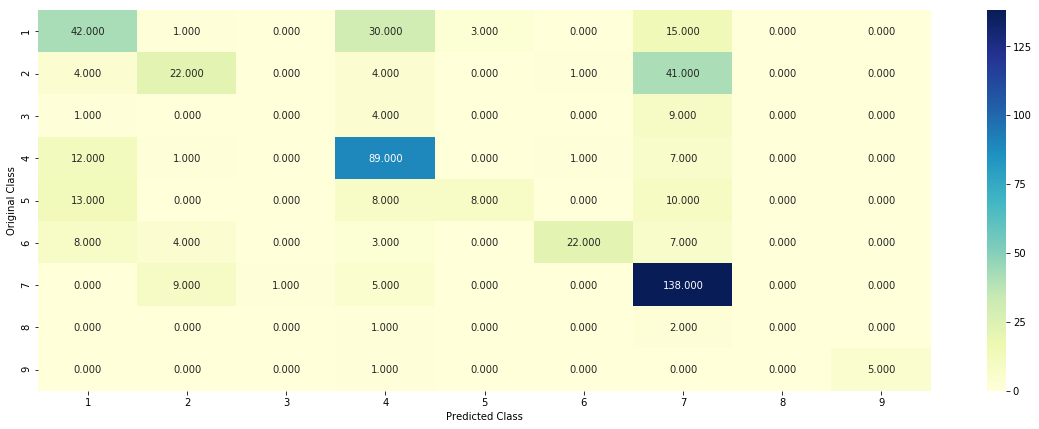

-------------------- Precision matrix (Columm Sum=1) --------------------


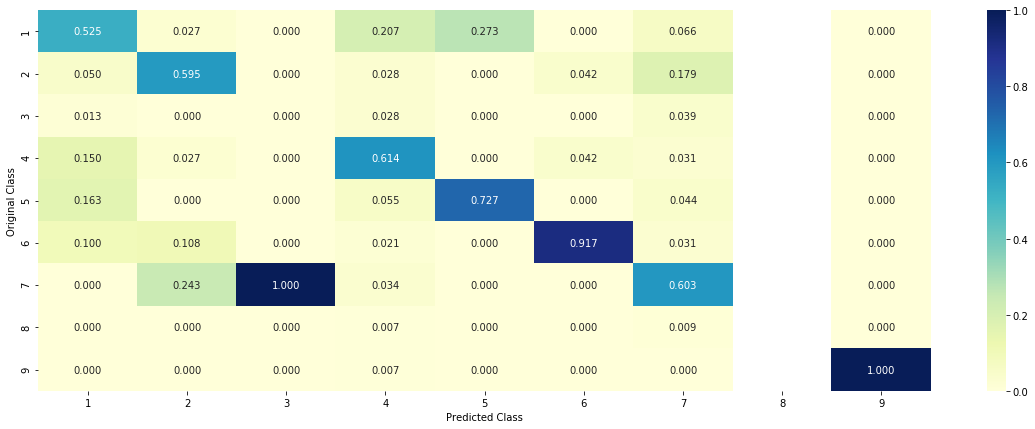

-------------------- Recall matrix (Row sum=1) --------------------


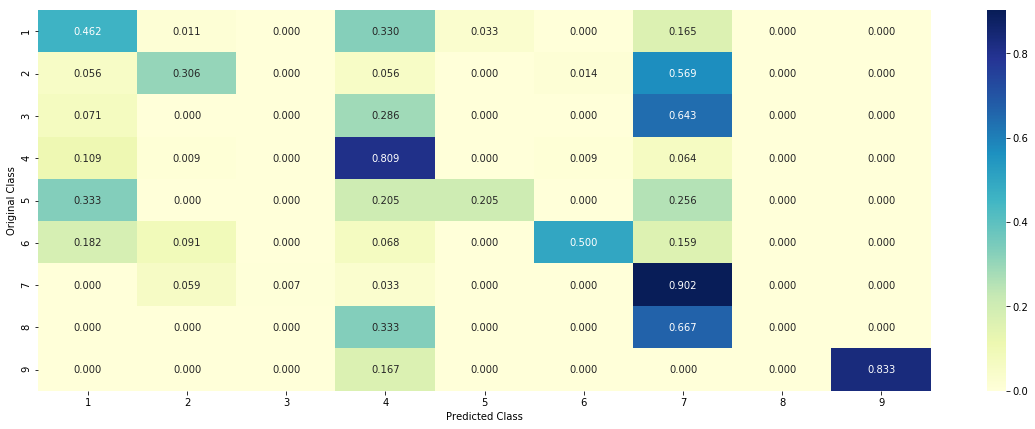

In [48]:
clf = RandomForestClassifier(n_estimators=200 ,criterion='gini', max_depth=10, random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_bigram, train_y,cv_x_bigram,cv_y,clf)

In [49]:
clf = RandomForestClassifier(n_estimators=200, criterion='gini', max_depth=10, random_state=42, n_jobs=-1)
clf.fit(train_x_bigram, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_bigram, train_y)


test_point_index = 5
no_feature = 27
predicted_cls = sig_clf.predict(test_x_bigram.toarray()[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_bigram.toarray()[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names_bigram(indices[:no_feature], test_df['Text'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.2192 0.0303 0.0307 0.3627 0.0813 0.2143 0.0501 0.0055 0.006 ]]
Actual Class : 6
--------------------------------------------------
0 Text feature [treated] present in test data point [True]
2 Text feature [activating] present in test data point [True]
3 Text feature [kinase] present in test data point [True]
4 Text feature [inhibitor] present in test data point [True]
7 Text feature [pathogenic] present in test data point [True]
10 Text feature [activated] present in test data point [True]
12 Text feature [yeast] present in test data point [True]
14 Text feature [phosphorylation] present in test data point [True]
16 Text feature [autophosphorylation] present in test data point [True]
17 Text feature [tumors] present in test data point [True]
18 Text feature [m18t] present in test data point [True]
26 Text feature [frameshift] present in test data point [True]
Out of the top  27  features  12 are present in query point


### Stacking up classifiers

In [62]:
from sklearn.svm import SVC
clf1 = KNeighborsClassifier(n_neighbors=4)
clf1.fit(train_x_bigram, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_bigram, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_bigram, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

clf4 = LogisticRegression(C=10)
clf4.fit(train_x_bigram, train_y)
sig_clf4 = CalibratedClassifierCV(clf4, method="sigmoid")

sig_clf1.fit(train_x_bigram, train_y)
print("KNN  :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_bigram))))
sig_clf2.fit(train_x_bigram, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_bigram))))
sig_clf3.fit(train_x_bigram, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_bigram))))
sig_clf4.fit(train_x_bigram, train_y)
print("Logistic Clasifier : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_bigram))))

print("-"*50)


KNN  :  Log Loss: 1.11
Support vector machines : Log Loss: 1.60
Naive Bayes : Log Loss: 1.18
Logistic Clasifier : Log Loss: 1.18
--------------------------------------------------


In [55]:
alpha = [0.0001,0.001,0.01,0.1,1,10,100] 
best_alpha = 999
for i in alpha:
    lr = SVC(C=i,probability=True,class_weight='balanced')
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_bigram, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss(train): %0.3f" % (i, log_loss(train_y, sclf.predict_proba(train_x_bigram))))
    print("Stacking Classifer : for the value of alpha: %f Log Loss(cross_validation): %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_bigram))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_bigram))
    if best_alpha > log_error:
        best_alpha = log_error

Stacking Classifer : for the value of alpha: 0.000100 Log Loss(train): 1.837
Stacking Classifer : for the value of alpha: 0.000100 Log Loss(cross_validation): 1.835
Stacking Classifer : for the value of alpha: 0.001000 Log Loss(train): 1.835
Stacking Classifer : for the value of alpha: 0.001000 Log Loss(cross_validation): 1.833
Stacking Classifer : for the value of alpha: 0.010000 Log Loss(train): 1.833
Stacking Classifer : for the value of alpha: 0.010000 Log Loss(cross_validation): 1.831
Stacking Classifer : for the value of alpha: 0.100000 Log Loss(train): 0.686
Stacking Classifer : for the value of alpha: 0.100000 Log Loss(cross_validation): 1.177
Stacking Classifer : for the value of alpha: 1.000000 Log Loss(train): 0.378
Stacking Classifer : for the value of alpha: 1.000000 Log Loss(cross_validation): 1.395
Stacking Classifer : for the value of alpha: 10.000000 Log Loss(train): 0.341
Stacking Classifer : for the value of alpha: 10.000000 Log Loss(cross_validation): 1.466
Stacking

In [60]:
alpha = [0.0001,0.001,0.01,0.1,1,10,100] 
best_alpha = 999
for i in alpha:
    lr = SVC(C=i,probability=True)
    sclf = StackingClassifier(classifiers=[sig_clf1,sig_clf3,sig_clf4], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_bigram, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss(train): %0.3f" % (i, log_loss(train_y, sclf.predict_proba(train_x_bigram))))
    print("Stacking Classifer : for the value of alpha: %f Log Loss(cross_validation): %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_bigram))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_bigram))
    if best_alpha > log_error:
        best_alpha = log_error

Stacking Classifer : for the value of alpha: 0.000100 Log Loss(train): 0.222
Stacking Classifer : for the value of alpha: 0.000100 Log Loss(cross_validation): 1.544
Stacking Classifer : for the value of alpha: 0.001000 Log Loss(train): 0.221
Stacking Classifer : for the value of alpha: 0.001000 Log Loss(cross_validation): 1.527
Stacking Classifer : for the value of alpha: 0.010000 Log Loss(train): 0.209
Stacking Classifer : for the value of alpha: 0.010000 Log Loss(cross_validation): 1.517
Stacking Classifer : for the value of alpha: 0.100000 Log Loss(train): 0.183
Stacking Classifer : for the value of alpha: 0.100000 Log Loss(cross_validation): 1.450
Stacking Classifer : for the value of alpha: 1.000000 Log Loss(train): 0.111
Stacking Classifer : for the value of alpha: 1.000000 Log Loss(cross_validation): 1.384
Stacking Classifer : for the value of alpha: 10.000000 Log Loss(train): 0.044
Stacking Classifer : for the value of alpha: 10.000000 Log Loss(cross_validation): 1.370
Stacking

Log loss (train) on the stacking classifier : 0.5208391874636578
Log loss (CV) on the stacking classifier : 1.0851366870809958
Log loss (test) on the stacking classifier : 1.0625397806023131
Number of missclassified point : 0.3398496240601504
-------------------- Confusion matrix C --------------------


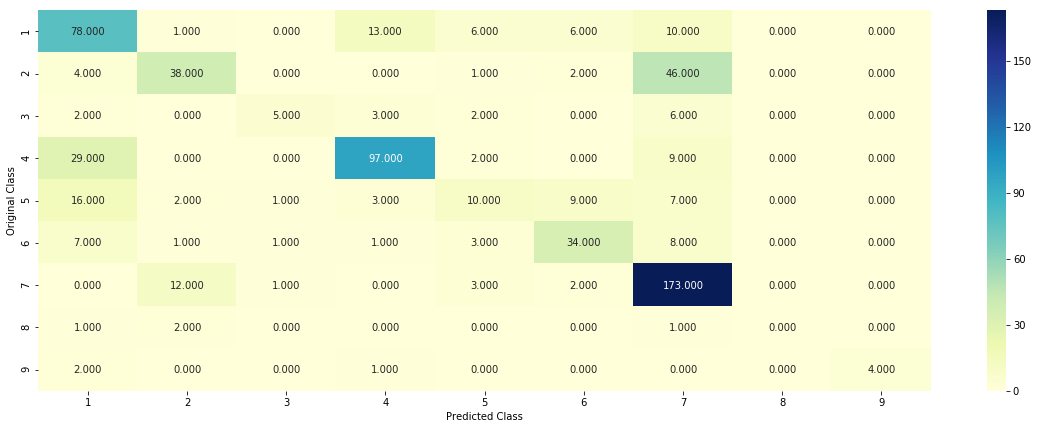

-------------------- Precision matrix (Columm Sum=1) --------------------


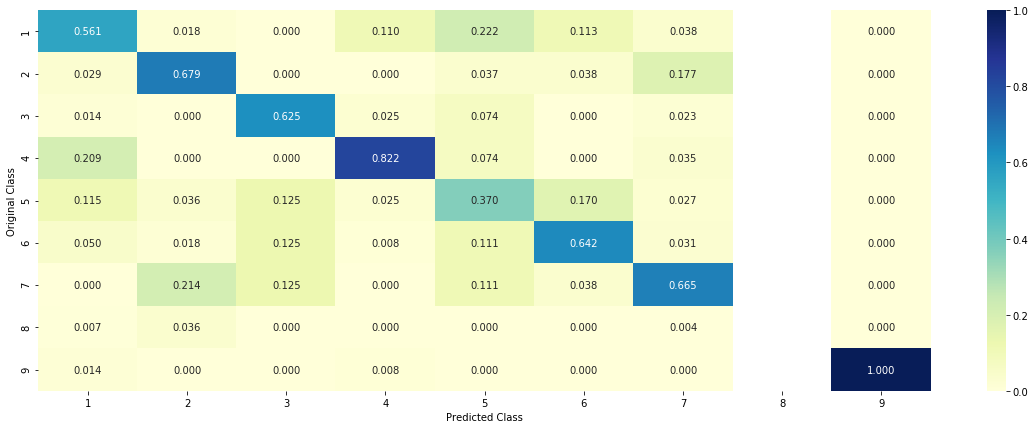

-------------------- Recall matrix (Row sum=1) --------------------


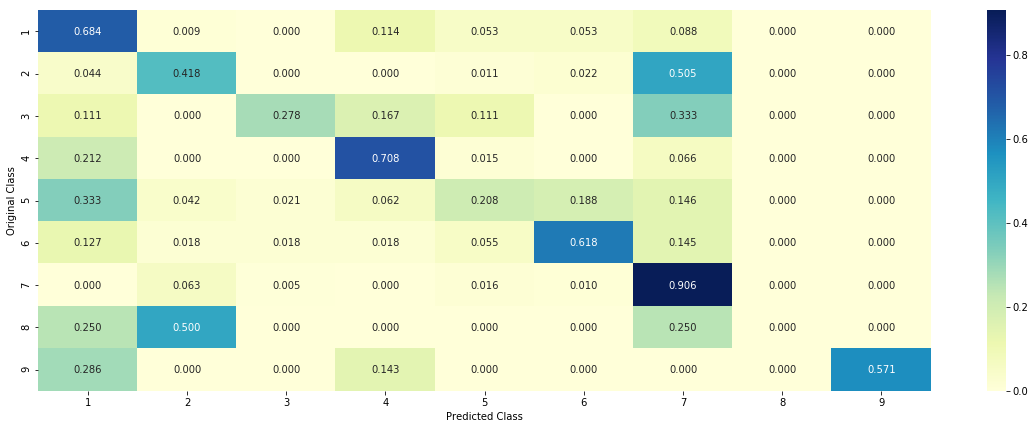

In [63]:

lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3,sig_clf4], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))

<b>Observation:</b> Stacking up classifiers can lead to overfit on train data which will result is bad performance over cross validation and training data

<h2>Maximum Voting Classifier</h2>

In [ ]:
####    one hot encoding
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('knn', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3),('lr',sig_clf4)], voting='soft')
vclf.fit(train_x_onehotCoding, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_onehotCoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_onehotCoding)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_onehotCoding)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_onehotCoding))

Log loss (train) on the VotingClassifier : 0.7621979460112199
Log loss (CV) on the VotingClassifier : 1.0489566490448852
Log loss (test) on the VotingClassifier : 1.0412330736051478
Number of missclassified point : 0.35639097744360904
-------------------- Confusion matrix C --------------------


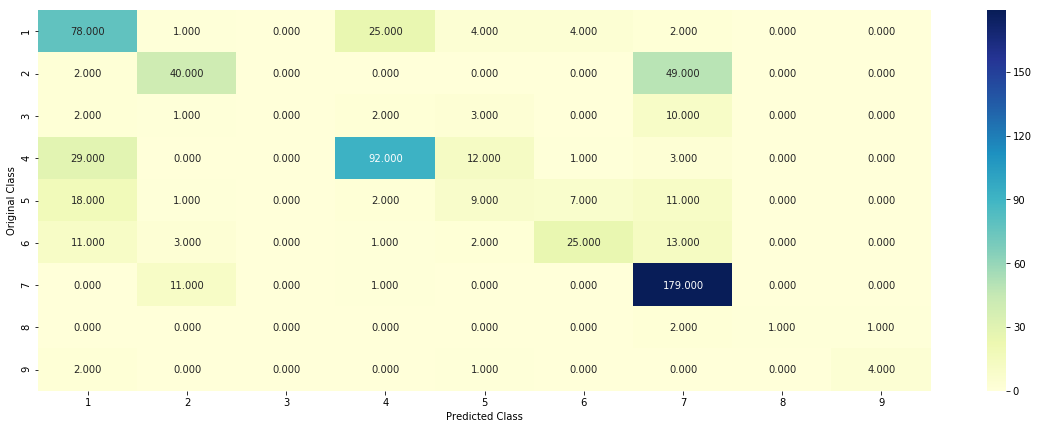

-------------------- Precision matrix (Columm Sum=1) --------------------


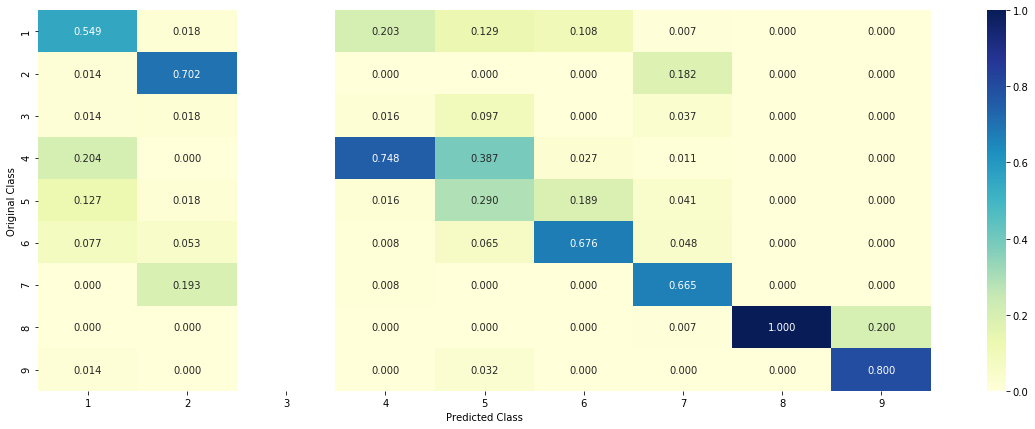

-------------------- Recall matrix (Row sum=1) --------------------


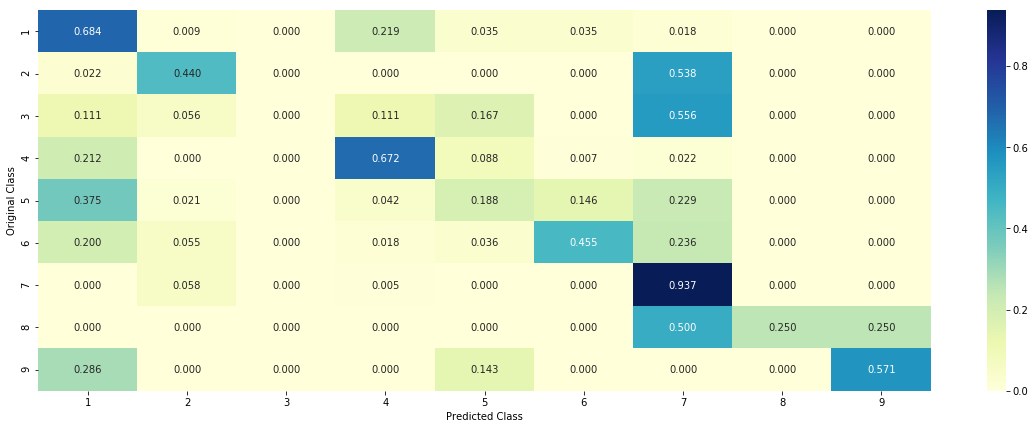

In [65]:
####  Response Coding
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('knn', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3),('lr',sig_clf4)], voting='soft')
vclf.fit(train_x_responseCoding, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_responseCoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_responseCoding)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_responseCoding)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_responseCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_responseCoding))

Log loss (train) on the VotingClassifier : 0.7623380577392915
Log loss (CV) on the VotingClassifier : 1.102588529848579
Log loss (test) on the VotingClassifier : 1.1268846559055785
Number of missclassified point : 0.3218045112781955
-------------------- Confusion matrix C --------------------


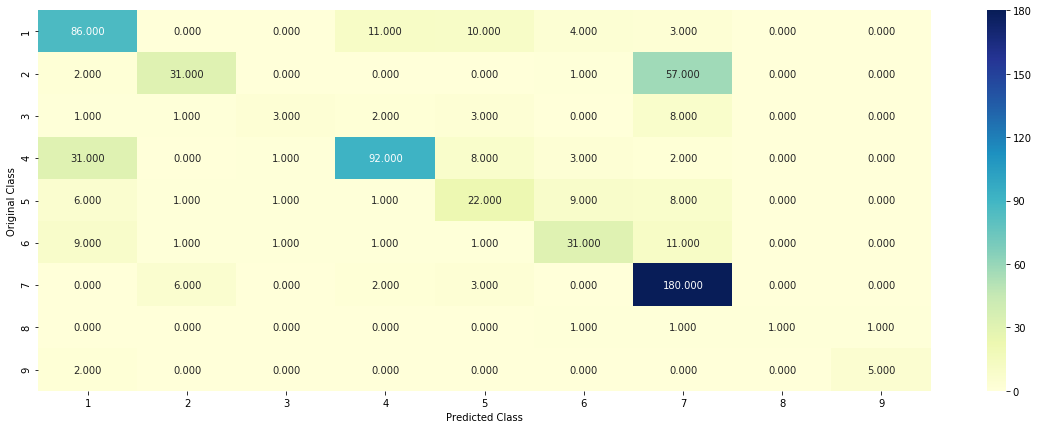

-------------------- Precision matrix (Columm Sum=1) --------------------


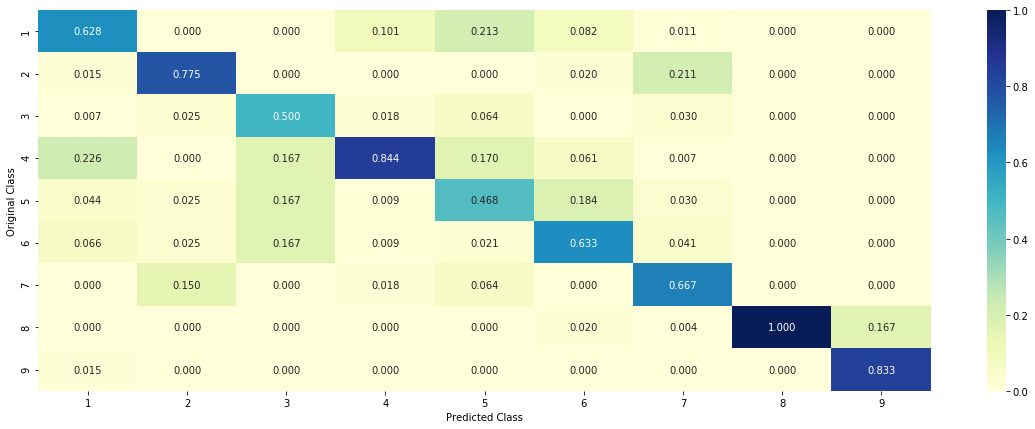

-------------------- Recall matrix (Row sum=1) --------------------


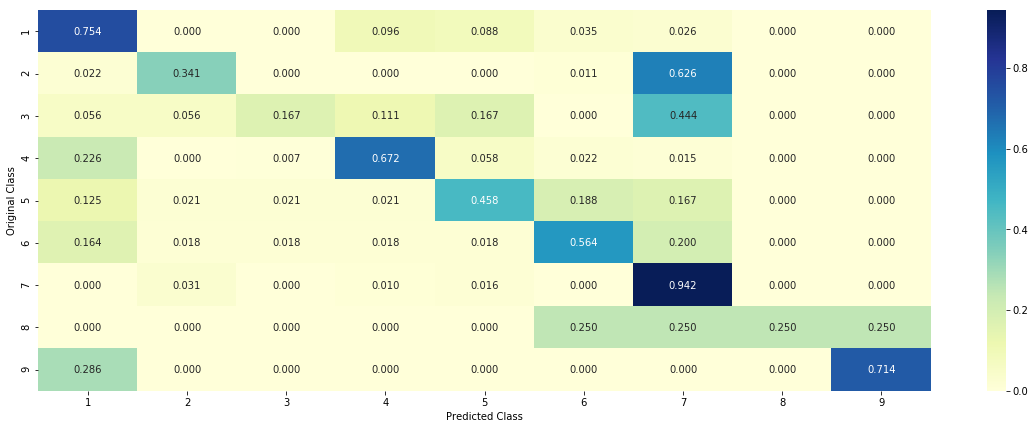

In [66]:
#### tfidf
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('knn', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3),('lr',sig_clf4)], voting='soft')
vclf.fit(train_x_tfidf, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_tfidf)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_tfidf)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_tfidf)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_tfidf)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_tfidf))

Log loss (train) on the VotingClassifier : 0.765755529719678
Log loss (CV) on the VotingClassifier : 1.2281775962507377
Log loss (test) on the VotingClassifier : 1.1889614995754785
Number of missclassified point : 0.39398496240601505
-------------------- Confusion matrix C --------------------


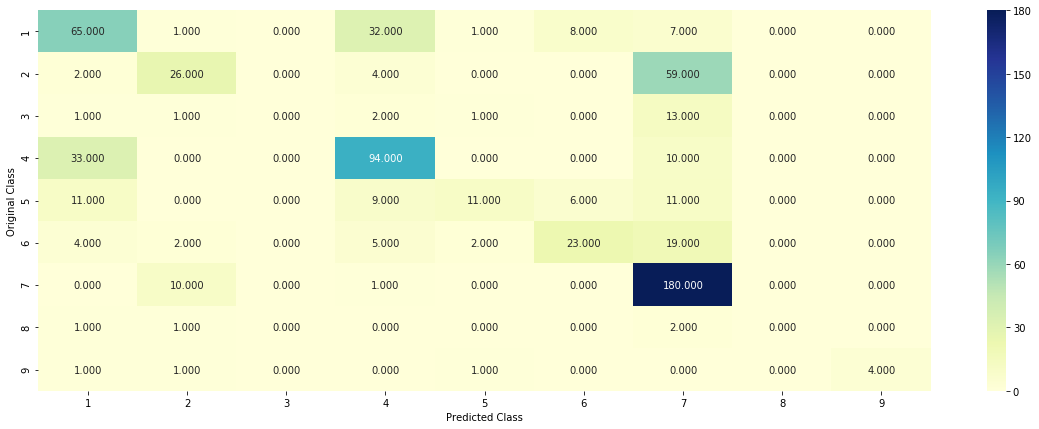

-------------------- Precision matrix (Columm Sum=1) --------------------


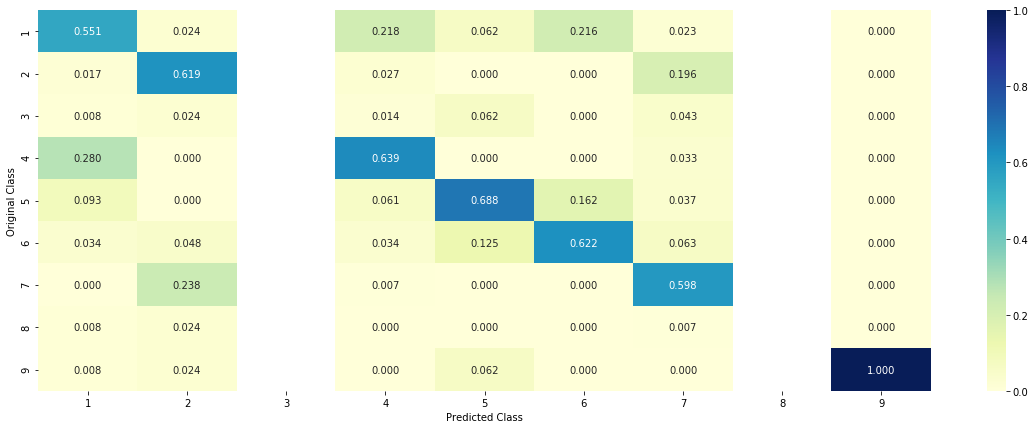

-------------------- Recall matrix (Row sum=1) --------------------


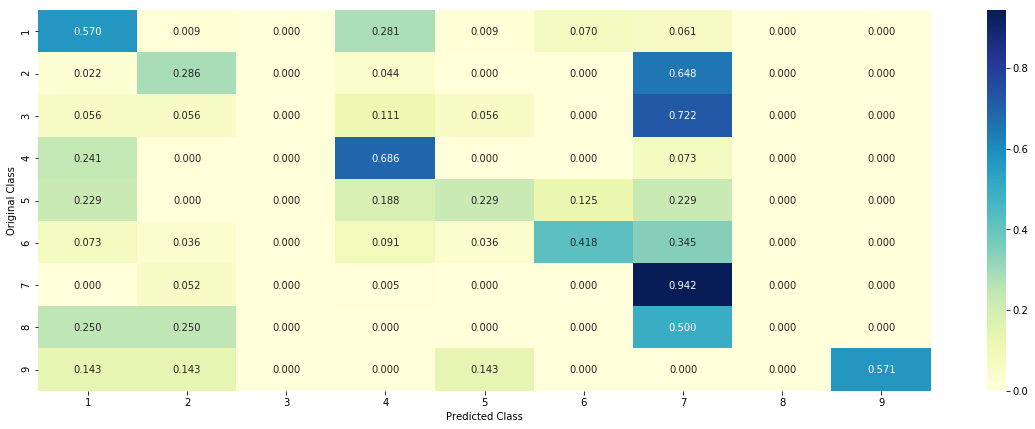

In [181]:
#### tfidf_1000
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('knn', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3),('lr',sig_clf4)], voting='soft')
vclf.fit(train_x_tfidf_1000, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_tfidf_1000)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_tfidf_1000)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_tfidf_1000)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_tfidf_1000)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_tfidf_1000))

Log loss (train) on the VotingClassifier : 0.7613998125281703
Log loss (CV) on the VotingClassifier : 1.1097173355195733
Log loss (test) on the VotingClassifier : 1.134926680038693
Number of missclassified point : 0.3263157894736842
-------------------- Confusion matrix C --------------------


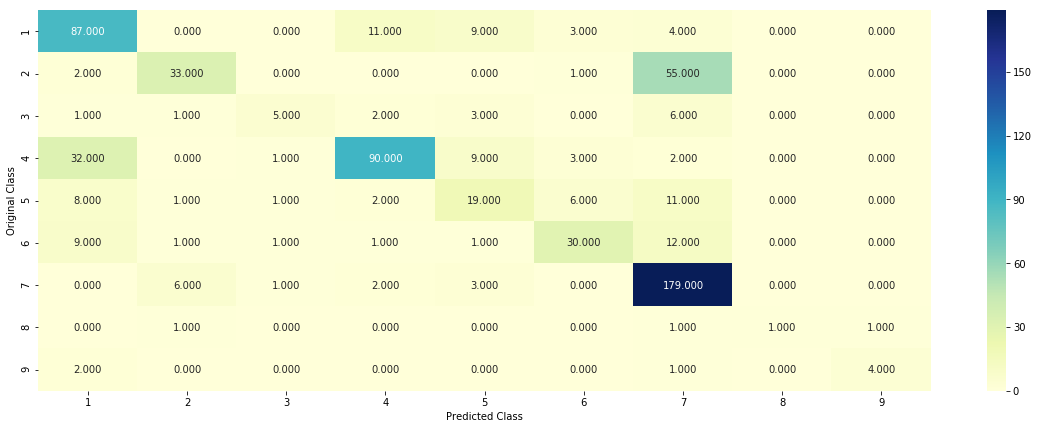

-------------------- Precision matrix (Columm Sum=1) --------------------


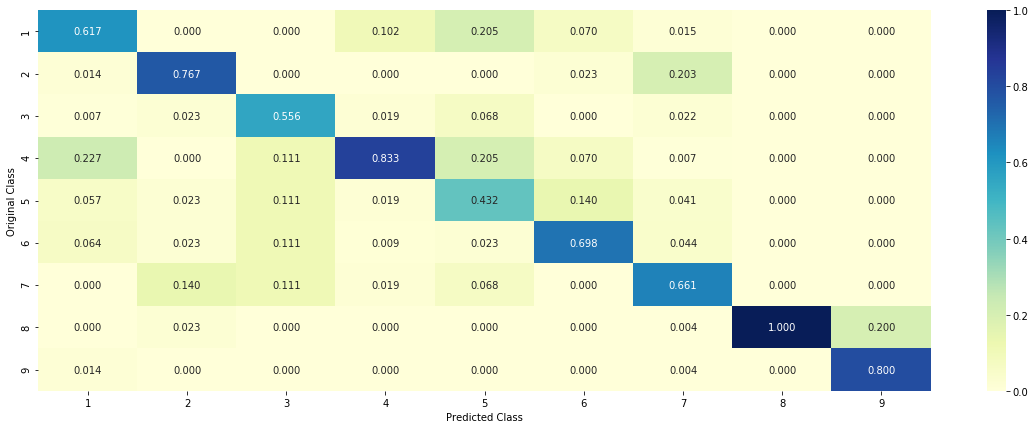

-------------------- Recall matrix (Row sum=1) --------------------


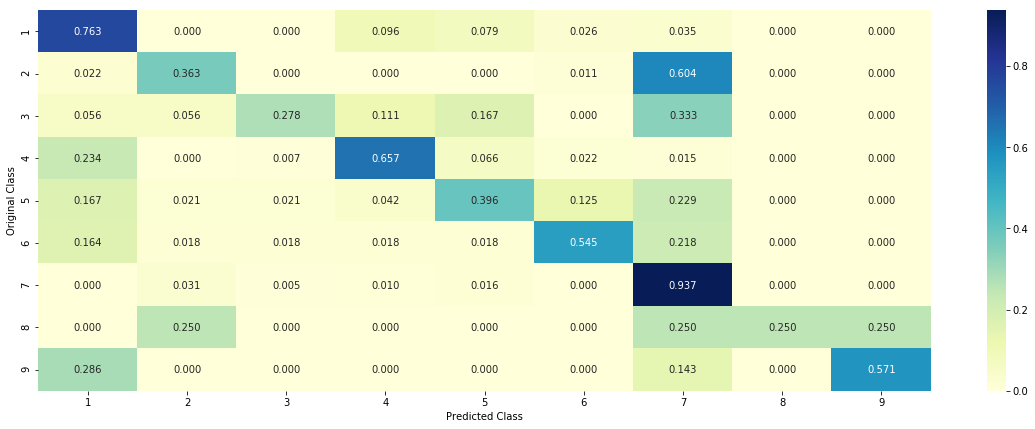

In [67]:
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('knn', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3),('lr',sig_clf4)], voting='soft')
vclf.fit(train_x_bigram, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_bigram)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_bigram)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_bigram)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_bigram)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_bigram))